# Humidity Prediction Study Analysis

This notebook analyzes experimental data from the trust and uncertainty visualization study.
The study examines how different visualization conditions affect user trust, confidence, and decision-making across two phases.

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
import json
import warnings
import math
warnings.filterwarnings('ignore')

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

# Set plotting style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

## 1. Data Loading and Preprocessing

In [2]:
# Utility helpers for flexible condition handling with new condition IDs
import re


def extract_condition_number(condition_id):
    """Extract numeric condition ID from strings like 'condition_17_buggy_checkbox'."""
    if pd.isna(condition_id):
        return None
    match = re.search(r"condition_(\d+)", str(condition_id))
    return int(match.group(1)) if match else None


def _fallback_condition_label(condition_id, condition_number):
    if pd.isna(condition_id):
        return f"Condition {condition_number}"

    parts = str(condition_id).split('_', 2)
    if len(parts) >= 3:
        return parts[2].replace('_', ' ').title()

    return f"Condition {condition_number}"


def build_condition_lookup(df, include_historical=True):
    """Build {condition_number: condition_name} from observed data."""
    if 'condition_id' not in df.columns:
        return {}

    subset_cols = ['condition_id']
    if 'condition_name' in df.columns:
        subset_cols.append('condition_name')

    observed = df[subset_cols].dropna(subset=['condition_id']).drop_duplicates()
    lookup = {}

    for _, row in observed.iterrows():
        cond_id = row['condition_id']
        cond_num = extract_condition_number(cond_id)
        if cond_num is None:
            continue
        if not include_historical and cond_num == 0:
            continue

        cond_name = row.get('condition_name') if 'condition_name' in observed.columns else None
        if pd.notna(cond_name) and str(cond_name).strip():
            label = str(cond_name).strip()
        else:
            label = _fallback_condition_label(cond_id, cond_num)

        lookup.setdefault(cond_num, label)

    return dict(sorted(lookup.items()))


def wrap_condition_label(label, max_words=2):
    """Wrap long labels for x-axis readability."""
    words = str(label).split()
    if len(words) > max_words:
        split = len(words) // 2
        return ' '.join(words[:split]) + '\n' + ' '.join(words[split:])
    return str(label)


In [3]:
# Load participant CSV files from data/ recursively (includes data/special)
candidate_roots = [Path('./data'), Path('./Experiment1/data')]
DATA_ROOT = next((p for p in candidate_roots if p.exists()), candidate_roots[0])
FILE_PATTERN = 'user_*.csv'
USE_RECURSIVE_SEARCH = True

csv_files = sorted(DATA_ROOT.rglob(FILE_PATTERN) if USE_RECURSIVE_SEARCH else DATA_ROOT.glob(FILE_PATTERN))

print(f"Using data root: {DATA_ROOT.resolve()}")
print(f"Found {len(csv_files)} participant data files:")

folder_counts = {}
for file in csv_files:
    rel_parent = str(file.parent.relative_to(DATA_ROOT)) if file.parent != DATA_ROOT else '.'
    folder_counts[rel_parent] = folder_counts.get(rel_parent, 0) + 1

print("\nFiles by folder:")
for folder, count in sorted(folder_counts.items()):
    print(f"  - {folder}: {count}")

print("\nSample files:")
for file in csv_files[:20]:
    print(f"  - {file.relative_to(DATA_ROOT)}")
if len(csv_files) > 20:
    print(f"  ... and {len(csv_files) - 20} more")


Using data root: /Users/songwen/Documents/Code Lab/Interact4Trust/Experiment1/data
Found 228 participant data files:

Files by folder:
  - .: 173
  - special: 55

Sample files:
  - special/user_10956_2026-02-16T18-07-29-464.csv
  - special/user_50092079953154997_2026-02-16T18-23-56-511.csv
  - special/user_503881540379_2026-02-16T18-09-43-432.csv
  - special/user_512483633_2026-02-16T18-37-33-797.csv
  - special/user_5160423184071038_2026-02-16T18-37-44-332.csv
  - special/user_5203679249926_2026-02-16T18-12-48-221.csv
  - special/user_534501000001072_2026-02-16T18-07-49-944.csv
  - special/user_5424244975151_2026-02-16T18-21-20-913.csv
  - special/user_560569410144194_2026-02-16T18-37-16-279.csv
  - special/user_5643607543000390_2026-02-16T18-29-21-425.csv
  - special/user_60384763501245822_2026-02-16T18-32-06-909.csv
  - special/user_60545888686109_2026-02-16T18-13-24-710.csv
  - special/user_606306508571_2026-02-16T18-13-40-107.csv
  - special/user_608598205009673921_2026-02-16T18-3

In [4]:
# Function to load and clean individual participant data
def load_participant_data(file_path):
	"""Load a single participant CSV file and clean the data"""
	try:
		df = pd.read_csv(file_path)
		
		# Extract participant ID from filename if not in data
		if 'participant_id' not in df.columns or df['participant_id'].isna().all():
			participant_id = file_path.stem.split('_')[1]  # Extract from filename
			df['participant_id'] = participant_id
		
		# Clean condition IDs and names
		if 'condition_id' in df.columns:
			df['condition_id'] = df['condition_id'].fillna('unknown')
		
		return df
	except Exception as e:
		print(f"Error loading {file_path}: {e}")
		return None

# Load all participant data
all_data = []
for file_path in csv_files:
	participant_data = load_participant_data(file_path)
	if participant_data is not None:
		all_data.append(participant_data)
		print(f"Loaded data for participant: {participant_data['participant_id'].iloc[0] if not participant_data['participant_id'].isna().all() else 'unknown'}")

# Combine all participant data
if all_data:
	combined_data = pd.concat(all_data, ignore_index=True)
	print(f"\nCombined dataset shape (before filtering): {combined_data.shape}")
	
	# Filter out test participants
	test_participants = ['test', 'Test', 'TEST']
	before_count = combined_data['participant_id'].nunique()
	combined_data = combined_data[~combined_data['participant_id'].isin(test_participants)]
	combined_data = combined_data[combined_data['participant_id'].notna()]  # Also remove NaN participants
	after_count = combined_data['participant_id'].nunique()
	
	print(f"Filtered out test participants and NaN entries")
	print(f"Participants: {before_count} → {after_count}")
	print(f"Final dataset shape: {combined_data.shape}")
else:
	print("No data loaded successfully")

Loaded data for participant: comp10956pilot
Loaded data for participant: 5dcccec0092079953154f997
Loaded data for participant: 5e0b388b15ef4037cebdecc9
Loaded data for participant: 5ddd1dd2b48da3c63a3ccdbb
Loaded data for participant: 5e1bfb604231d840ef7103d8
Loaded data for participant: 5f2f03deec679e2cf4a992e6
Loaded data for participant: 5ab3fc4b5f01000001cb07e2
Loaded data for participant: 5f4df2b4bdb2449bd751ce51
Loaded data for participant: 5f6056e9a41e0d14d4c19f4c
Loaded data for participant: 56b43607c54e3c000d3c9b0b
Loaded data for participant: 603ecd847a63f50124aa5822
Loaded data for participant: 60ec54c58f88686dadb1a0c9
Loaded data for participant: 60e63a06acbec5f0fc85e71a
Loaded data for participant: 60859f820e5009a67adb3921
Loaded data for participant: 6155e95c0808b015514b34e0
Loaded data for participant: 62c026818910950fc380e599
Loaded data for participant: 62e19208352cd518d7b2f085
Loaded data for participant: 62e2deadd18974300540f870
Loaded data for participant: 63d02c1f6

In [5]:
# Function to identify participants with inconsistent responses
def identify_inconsistent_participants(df):
	"""
	Identify participants with inconsistent responses:
	- Choose City B but estimate P(City A > City B) < 50%
	- Choose City A but estimate P(City A > City B) > 50%
	
	Returns: DataFrame with inconsistent participants and their details
	"""
	inconsistent_participants = []
	
	# Get prediction task data only
	pred_data = df[df['trial_type'] == 'prediction-task'].copy()
	
	for participant_id in pred_data['participant_id'].unique():
		participant_rows = pred_data[pred_data['participant_id'] == participant_id]
		
		for _, row in participant_rows.iterrows():
			prob_est = row.get('probability_estimate')
			travel_choice = row.get('travel_choice')
			phase = row.get('phase', 'unknown')
			condition = row.get('condition_name', 'unknown')
			
			if pd.notna(prob_est) and pd.notna(travel_choice) and travel_choice in ['City A', 'City B']:
				# Check for inconsistency
				is_inconsistent = False
				inconsistency_type = None
				
				if travel_choice == 'City B' and prob_est < 50:
					# Participant chooses City B but thinks City A has lower probability
					is_inconsistent = True
					inconsistency_type = 'chose_city_b_but_low_prob_cityA'
				elif travel_choice == 'City A' and prob_est > 50:
					# Participant chooses City A but thinks City A has higher probability  
					is_inconsistent = True
					inconsistency_type = 'chose_city_a_but_high_prob_cityA'
				
				if is_inconsistent:
					inconsistent_participants.append({
						'participant_id': participant_id,
						'phase': phase,
						'condition': condition,
						'travel_choice': travel_choice,
						'probability_estimate': prob_est,
						'inconsistency_type': inconsistency_type
					})
	
	return pd.DataFrame(inconsistent_participants)

def filter_consistent_participants(df, verbose=True):
	"""
	Filter out participants with inconsistent responses
	
	Args:
		df: Original dataframe
		verbose: Print filtering details
		
	Returns:
		Filtered dataframe with consistent participants only
	"""
	# Identify inconsistent participants
	inconsistent_df = identify_inconsistent_participants(df)
	
	if len(inconsistent_df) > 0:
		inconsistent_participant_ids = inconsistent_df['participant_id'].unique()
		
		if verbose:
			print(f"Found {len(inconsistent_participant_ids)} participants with inconsistent responses:")
			for participant_id in inconsistent_participant_ids:
				participant_issues = inconsistent_df[inconsistent_df['participant_id'] == participant_id]
				print(f"  {participant_id}:")
				for _, issue in participant_issues.iterrows():
					print(f"    Phase {issue['phase']}: chose {issue['travel_choice']} but estimated P(City A > City B) = {issue['probability_estimate']}%")
		
		# Filter out inconsistent participants
		filtered_df = df[~df['participant_id'].isin(inconsistent_participant_ids)].copy()
		
		if verbose:
			original_participants = df['participant_id'].nunique()
			filtered_participants = filtered_df['participant_id'].nunique()
			print(f"\nFiltering results:")
			print(f"  Original participants: {original_participants}")
			print(f"  Inconsistent participants removed: {len(inconsistent_participant_ids)}")
			print(f"  Remaining participants: {filtered_participants}")
		
		return filtered_df, inconsistent_df
	else:
		if verbose:
			print("No inconsistent participants found.")
		return df, pd.DataFrame()

print("Consistency checking functions defined.")

Consistency checking functions defined.


In [6]:
# Examine the data structure
print("Column names:")
print(combined_data.columns.tolist())
print(f"\nDataset shape: {combined_data.shape}")
# print(f"\nUnique trial types:")
# print(combined_data['trial_type'].value_counts())

Column names:
['city_a_estimate', 'city_b_estimate', 'click_events', 'comprehension_ease', 'condition', 'condition_id', 'condition_name', 'confidence_label', 'confidence_rating', 'data_trust', 'device_pixel_ratio', 'display_format', 'end_time', 'failed_audio', 'failed_images', 'failed_video', 'hover_events', 'interaction_log', 'internal_node_id', 'participant_id', 'percent_score', 'phase', 'phase1_complete', 'phase2_complete', 'predictions_shown', 'probability_estimate', 'question_order', 'response', 'responses', 'round', 'rt', 'rt_total', 'screen_height', 'screen_width', 'skeptical_rating', 'slider_moved', 'start_time', 'stimulus', 'success', 'time_elapsed', 'time_on_viz', 'timeout', 'total_interactions', 'total_questions', 'total_score', 'travel_choice', 'trial_index', 'trial_type', 'trust_composite', 'usability_composite', 'usability_difficulty', 'view_history', 'visualization_literacy_score', 'visualization_shown']

Dataset shape: (4581, 54)


In [7]:
# Filter for relevant trial types (prediction tasks and surveys)
relevant_trials = combined_data[
	combined_data['trial_type'].isin([
		'prediction-task', 'vis-literacy', 'trust-survey', 
		'personality-survey', 'survey-text', 'survey-multi-choice'
	])
].copy()

print(f"Filtered dataset shape: {relevant_trials.shape}")
print(f"\nTrial types in filtered data:")
print(relevant_trials['trial_type'].value_counts())

Filtered dataset shape: (2035, 54)

Trial types in filtered data:
trial_type
survey-text            453
prediction-task        452
trust-survey           452
vis-literacy           226
personality-survey     226
survey-multi-choice    226
Name: count, dtype: int64


In [8]:
# Create interaction_freq column from interaction_log string length
relevant_trials['interaction_freq'] = np.log(relevant_trials['interaction_log'].astype(str).str.len())

print(f"Added interaction_freq column to relevant_trials dataset")
print(f"Dataset shape: {relevant_trials.shape}")
print(f"\nInteraction frequency statistics:")
print(relevant_trials['interaction_freq'].describe())

# Show a few sample values to verify the new column
print(f"\nSample interaction_log vs interaction_freq values:")
sample = relevant_trials[['interaction_log', 'interaction_freq']].head(5)
for idx, row in sample.iterrows():
	log_val = str(row['interaction_log'])[:50] + "..." if len(str(row['interaction_log'])) > 50 else str(row['interaction_log'])
	print(f"Log: {log_val} | Freq: {row['interaction_freq']}")

Added interaction_freq column to relevant_trials dataset
Dataset shape: (2035, 55)

Interaction frequency statistics:
count    2035.000000
mean        2.835065
std         3.645358
min         0.693147
25%         1.098612
50%         1.098612
75%         1.098612
max        13.625012
Name: interaction_freq, dtype: float64

Sample interaction_log vs interaction_freq values:
Log: nan | Freq: 1.0986122886681098
Log: nan | Freq: 1.0986122886681098
Log: [{"type":"chart_hover","data":{"x":794,"y":370,"ch... | Freq: 11.466891997618188
Log: [{"type":"chart_enter","data":{"x":678,"y":592,"ch... | Freq: 11.401714535634227
Log: nan | Freq: 1.0986122886681098


In [9]:
# # Apply consistency filtering to the dataset
# print("=" * 60)
# print("CHECKING FOR INCONSISTENT PARTICIPANTS")
# print("=" * 60)

# # Apply the filter to your combined_data
# combined_data, inconsistent_participants = filter_consistent_participants(combined_data, verbose=True)

# # Update the relevant_trials dataset as well
# if len(inconsistent_participants) > 0:
#     inconsistent_ids = inconsistent_participants['participant_id'].unique()
#     relevant_trials_filtered = relevant_trials[~relevant_trials['participant_id'].isin(inconsistent_ids)].copy()
#     print(f"\nRelevant trials dataset:")
#     print(f"  Original shape: {relevant_trials.shape}")
#     print(f"  Filtered shape: {relevant_trials_filtered.shape}")
# else:
#     relevant_trials_filtered = relevant_trials.copy()
	
# relevant_trials=relevant_trials_filtered
# print("\n" + "=" * 60)

In [10]:
# Examine condition distribution
print("Unique conditions:")
condition_counts = relevant_trials['condition_id'].value_counts(dropna=False)
print(condition_counts)

print("\nCondition names:")
condition_names = relevant_trials[['condition_id', 'condition_name']].drop_duplicates().dropna()
for _, row in condition_names.iterrows():
	print(f"  {row['condition_id']}: {row['condition_name']}")

Unique conditions:
condition_id
unknown                        226
condition_0_historical         226
condition_5_pi_hover           147
condition_7_buggy              140
condition_9_combined           140
condition_16_tiny_slider       133
condition_4_ensemble_hover     133
condition_6_pi_to_ensemble     133
condition_17_buggy_checkbox    126
condition_11_checkbox          126
condition_1_baseline           126
condition_8_bad                126
condition_2_pi_plot            126
condition_3_ensemble           126
NaN                              1
Name: count, dtype: int64

Condition names:
  condition_17_buggy_checkbox: Buggy Checkbox Selection
  condition_0_historical: Historical Only
  condition_11_checkbox: Checkbox Selection
  condition_16_tiny_slider: Tiny Slider Checkbox
  condition_1_baseline: Baseline
  condition_7_buggy: Buggy Control
  condition_8_bad: Bad Control
  condition_4_ensemble_hover: Ensemble + Hover
  condition_6_pi_to_ensemble: PI → Ensemble
  condition_2_pi_p

In [11]:
# Separate Phase 1 and Phase 2 data
prediction_data = relevant_trials[relevant_trials['trial_type'] == 'prediction-task'].copy()

# Phase separation logic
phase1_data = prediction_data[prediction_data['phase'] == 1].copy()
phase2_data = prediction_data[prediction_data['phase'] == 2].copy()

print(f"Phase 1 data: {len(phase1_data)} rows")
print(f"Phase 2 data: {len(phase2_data)} rows")

# Get visualization literacy data
vis_literacy_data = relevant_trials[relevant_trials['trial_type'] == 'vis-literacy'].copy()
print(f"Visualization literacy data: {len(vis_literacy_data)} rows")

# Separate different types of survey data

# Get trust-survey data (interface interaction and visualization trust questions)
all_trust_surveys = relevant_trials[relevant_trials['trial_type'] == 'trust-survey'].copy()
print(f"All trust survey data: {len(all_trust_surveys)} rows")

# Get personality survey data (demographics questions)
all_personality_surveys = relevant_trials[relevant_trials['trial_type'] == 'personality-survey'].copy()
print(f"All personality survey data: {len(all_personality_surveys)} rows")

# Function to check if a row represents a specific survey type based on question_order
def get_survey_type(row):
	"""Determine survey type based on question_order content"""
	if 'question_order' in row and pd.notna(row['question_order']):
		try:
			question_order = eval(row['question_order'])  # Convert string to list
			if isinstance(question_order, list) and len(question_order) > 0:
				first_question = question_order[0]
				
				# Define the first question of each survey type
				if first_question == 'navigation_control':
					return 'interaction'
				elif first_question == 'skeptical_rating':
					return 'trust'
				elif first_question == 'respect_others':
					return 'demographics'
		except:
			pass
	return 'unknown'

# Add survey type classification to trust surveys
all_trust_surveys['survey_type'] = all_trust_surveys.apply(get_survey_type, axis=1)

# Separate the data based on survey types
interaction_data = all_trust_surveys[all_trust_surveys['survey_type'] == 'interaction'].copy()
trust_data = all_trust_surveys[all_trust_surveys['survey_type'] == 'trust'].copy()
demographics_data = all_personality_surveys.copy()  # Demographics is in personality-survey trial type

print(f"Interaction data: {len(interaction_data)} rows")
print(f"Trust data: {len(trust_data)} rows") 
print(f"Demographics data: {len(demographics_data)} rows")

# Show survey type distribution
print(f"\nTrust survey type distribution:")
print(all_trust_surveys['survey_type'].value_counts())

Phase 1 data: 226 rows
Phase 2 data: 226 rows
Visualization literacy data: 226 rows
All trust survey data: 452 rows
All personality survey data: 226 rows
Interaction data: 226 rows
Trust data: 226 rows
Demographics data: 226 rows

Trust survey type distribution:
survey_type
interaction    226
trust          226
Name: count, dtype: int64


## 2. Basic Statistics Tables by Condition

Each table shows conditions as rows and response variables as columns, with participant response lists in each cell.

In [12]:
def create_condition_response_table(data, response_columns, title="Response Table"):
	"""
	Create a table where each row is a condition and each column is a response variable.
	Each cell contains a list of participant responses.
	"""
	# Get unique conditions
	conditions = sorted(data['condition_id'].dropna().unique())
	
	# Initialize results dictionary
	results = {}
	
	for condition in conditions:
		condition_data = data[data['condition_id'] == condition]
		condition_responses = {}
		
		for col in response_columns:
			if col in condition_data.columns:
				responses = condition_data[col].dropna().tolist()
				condition_responses[col] = responses
			else:
				condition_responses[col] = []
		
		results[condition] = condition_responses
	
	# Convert to DataFrame
	df = pd.DataFrame(results).T
	
	print(f"\n{title}")
	print("=" * len(title))
	return df

# Function to display response summary statistics
def display_response_summary(df, title="Summary"):
	"""
	Display summary statistics for response lists in each cell
	"""
	print(f"\n{title} - Response Counts and Basic Stats")
	print("-" * (len(title) + 30))
	
	for condition in df.index:
		print(f"\nCondition: {condition}")
		for col in df.columns:
			responses = df.loc[condition, col]
			if isinstance(responses, list) and responses:
				numeric_responses = [r for r in responses if isinstance(r, (int, float)) and not pd.isna(r)]
				if numeric_responses:
					print(f"  {col}: n={len(numeric_responses)}, mean={np.mean(numeric_responses):.2f}, responses={numeric_responses}")
				else:
					print(f"  {col}: n={len(responses)}, responses={responses[:5]}{'...' if len(responses) > 5 else ''}")
			else:
				print(f"  {col}: No responses")
	
	return df

### Phase 1 Responses (Baseline - No Visualization)

In [13]:
# Phase 1 response columns
phase1_columns = ['probability_estimate', 'confidence_rating', 'travel_choice']

# Create Phase 1 table
phase1_table = create_condition_response_table(
	phase1_data, 
	phase1_columns, 
	"Phase 1 Responses (No Visualization)"
)

# Display the table
# display_response_summary(phase1_table, "Phase 1 Summary")


Phase 1 Responses (No Visualization)


### Phase 2 Responses (With Visualization)

In [14]:
# Phase 2 response columns
phase2_columns = ['probability_estimate', 'confidence_rating', 'travel_choice', 'data_trust', 'skeptical_rating']

# Create Phase 2 table
phase2_table = create_condition_response_table(
	phase2_data, 
	phase2_columns, 
	"Phase 2 Responses (With Visualization)"
)

# Display the table
# display_response_summary(phase2_table, "Phase 2 Summary")


Phase 2 Responses (With Visualization)


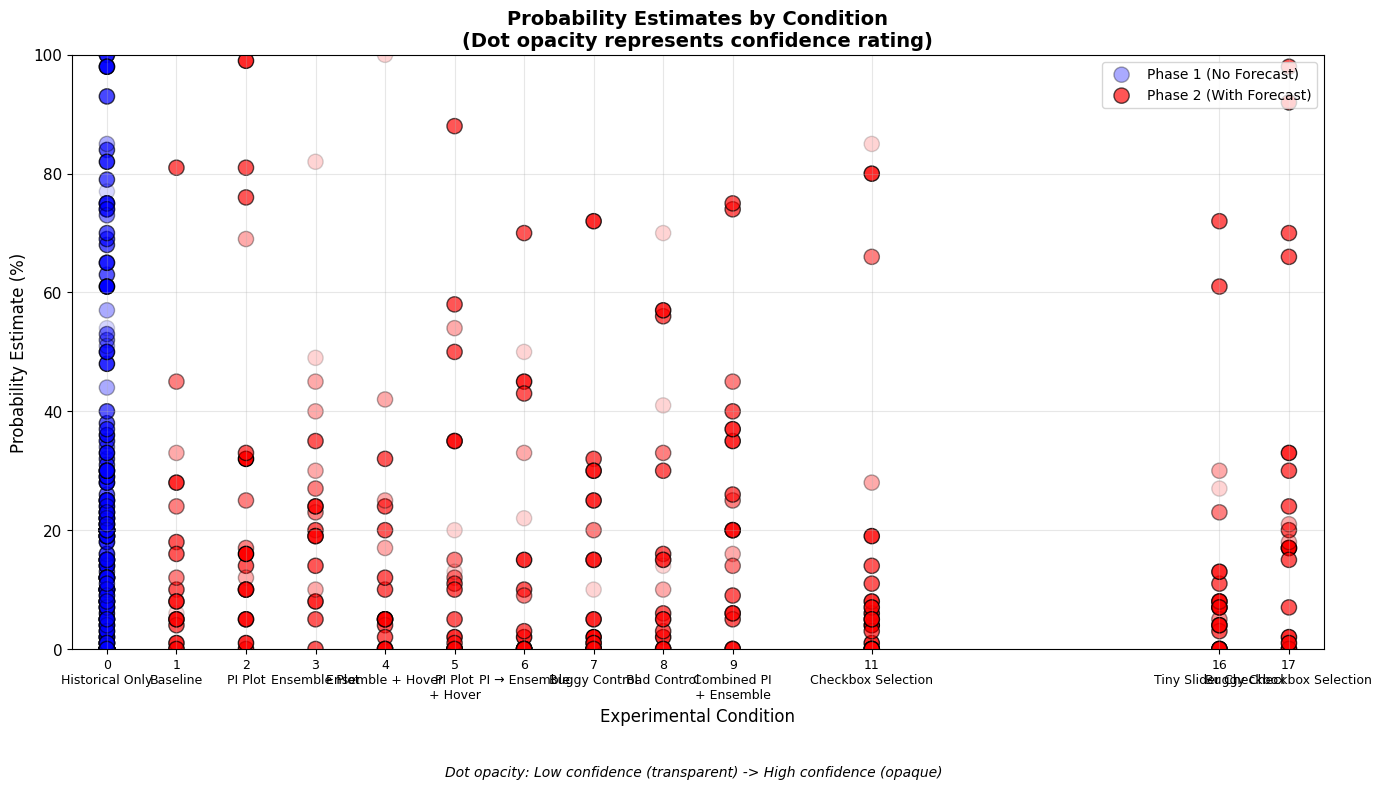


Visualization Data Summary:
phase_label
Phase 1    226
Phase 2    226
Conditions with data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 16, 17]

Condition Mapping:
  ✓ Condition 0: Historical Only
  ✓ Condition 1: Baseline
  ✓ Condition 2: PI Plot
  ✓ Condition 3: Ensemble Plot
  ✓ Condition 4: Ensemble + Hover
  ✓ Condition 5: PI Plot + Hover
  ✓ Condition 6: PI → Ensemble
  ✓ Condition 7: Buggy Control
  ✓ Condition 8: Bad Control
  ✓ Condition 9: Combined PI + Ensemble
  ✓ Condition 11: Checkbox Selection
  ✓ Condition 16: Tiny Slider Checkbox
  ✓ Condition 17: Buggy Checkbox Selection


In [15]:
# Create combined dot plot visualization with probability estimates by condition
# Opacity based on confidence rating

def create_probability_dot_plot():
    """Create a dot plot of probability estimates by observed condition IDs."""

    viz_df = prediction_data[['condition_id', 'probability_estimate', 'confidence_rating', 'phase']].copy()
    viz_df = viz_df.dropna(subset=['condition_id', 'probability_estimate', 'confidence_rating'])
    viz_df['condition_number'] = viz_df['condition_id'].apply(extract_condition_number)
    viz_df = viz_df[viz_df['condition_number'].notna()].copy()

    if viz_df.empty:
        print("No data available for visualization")
        return None

    viz_df['condition_number'] = viz_df['condition_number'].astype(int)
    viz_df['phase_label'] = viz_df['phase'].map({1: 'Phase 1', 2: 'Phase 2'}).fillna('Other')
    viz_df['opacity'] = (viz_df['confidence_rating'] - 1) / 6

    condition_lookup = build_condition_lookup(relevant_trials, include_historical=True)
    present_conditions = sorted(viz_df['condition_number'].unique())
    all_conditions = sorted(set(condition_lookup.keys()) | set(present_conditions))

    fig, ax = plt.subplots(1, 1, figsize=(14, 8))

    style_by_phase = {
        'Phase 1': {'color': 'blue', 'label': 'Phase 1 (No Forecast)'},
        'Phase 2': {'color': 'red', 'label': 'Phase 2 (With Forecast)'},
        'Other': {'color': 'gray', 'label': 'Other'}
    }

    for phase_label, style in style_by_phase.items():
        phase_data = viz_df[viz_df['phase_label'] == phase_label]
        if not phase_data.empty:
            ax.scatter(
                phase_data['condition_number'],
                phase_data['probability_estimate'],
                alpha=phase_data['opacity'],
                s=120,
                c=style['color'],
                edgecolors='black',
                linewidth=1,
                label=style['label']
            )

    ax.set_title('Probability Estimates by Condition\n(Dot opacity represents confidence rating)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel('Probability Estimate (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3)

    ax.set_xlim(min(all_conditions) - 0.5, max(all_conditions) + 0.5)
    ax.set_xticks(all_conditions)

    labels = []
    for cond in all_conditions:
        name = condition_lookup.get(cond, f'Condition {cond}')
        labels.append(f"{cond}\n{wrap_condition_label(name, max_words=3)}")
    ax.set_xticklabels(labels, fontsize=9, ha='center')

    ax.legend(loc='upper right', fontsize=10)
    fig.text(0.5, 0.02, 'Dot opacity: Low confidence (transparent) -> High confidence (opaque)', ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.18)
    plt.show()

    print("\nVisualization Data Summary:")
    print(viz_df['phase_label'].value_counts().to_string())
    print(f"Conditions with data: {present_conditions}")

    print("\nCondition Mapping:")
    for cond in all_conditions:
        status = '✓' if cond in present_conditions else '✗'
        print(f"  {status} Condition {cond}: {condition_lookup.get(cond, f'Condition {cond}')}")

    return viz_df

# Create the visualization
viz_summary = create_probability_dot_plot()



Humidity Estimate Shift Summary:
Participants with matched baseline: 226
Interaction frequency range: 0.6931471805599453 - 13.625012060930079

Mean shift by condition (from Condition 0 baseline):
----------------------------------------------------------------------
  Condition 1 (Baseline): n=18
      City A: ↑ +6.28 (SD=7.98)
      City B: ↑ +7.39 (SD=7.21)
  Condition 2 (PI Plot): n=18
      City A: ↑ +6.03 (SD=6.03)
      City B: ↑ +7.87 (SD=4.39)
  Condition 3 (Ensemble Plot): n=18
      City A: ↑ +9.25 (SD=7.87)
      City B: ↑ +9.58 (SD=7.73)
  Condition 4 (Ensemble + Hover): n=19
      City A: ↑ +7.84 (SD=7.88)
      City B: ↑ +8.13 (SD=5.90)
  Condition 5 (PI Plot + Hover): n=21
      City A: ↑ +8.10 (SD=8.93)
      City B: ↑ +4.62 (SD=5.42)
  Condition 6 (PI → Ensemble): n=19
      City A: ↑ +5.32 (SD=16.39)
      City B: ↑ +2.11 (SD=16.74)
  Condition 7 (Buggy Control): n=20
      City A: ↑ +6.80 (SD=4.01)
      City B: ↑ +9.45 (SD=7.80)
  Condition 8 (Bad Control): n=18
  

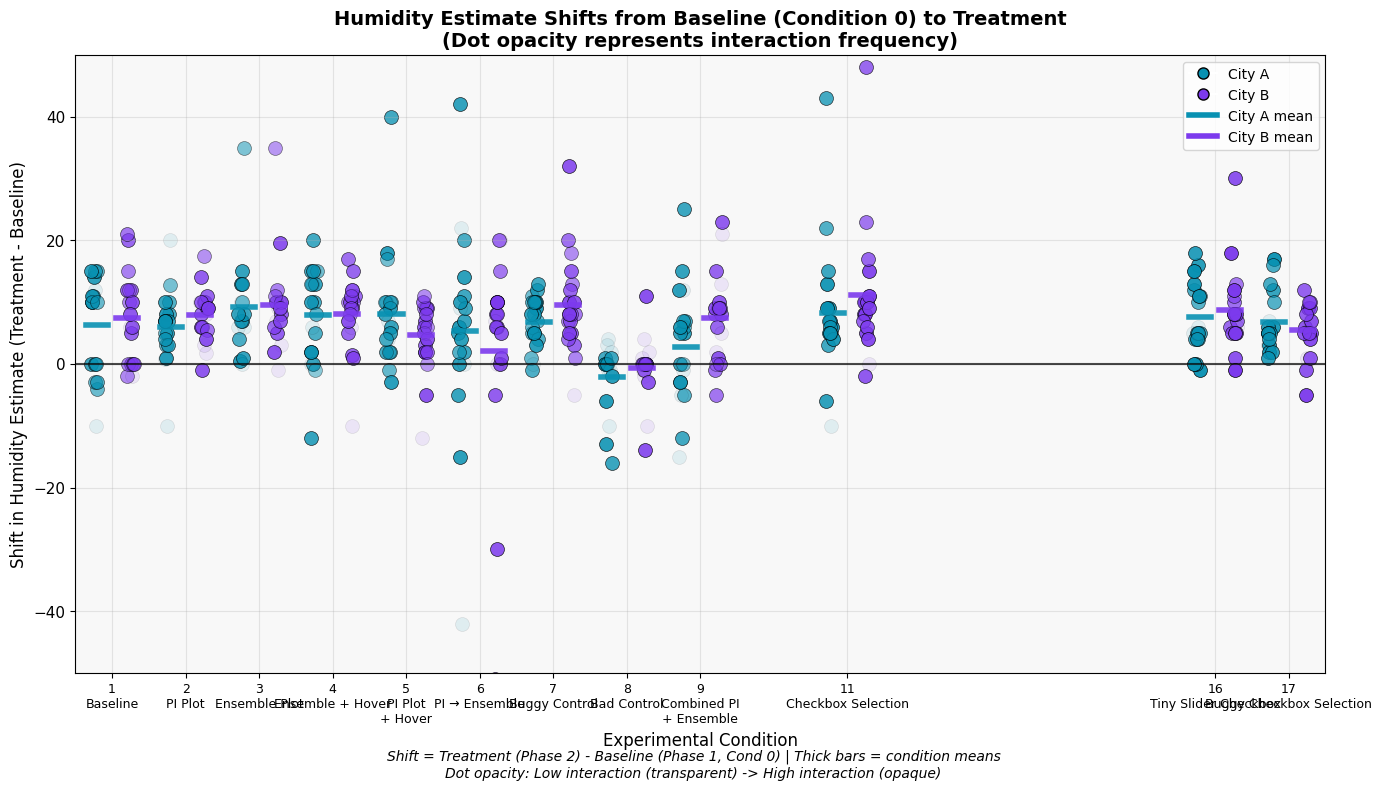

In [16]:
# Modified function to use interaction_freq for opacity instead of confidence
def create_probability_shift_plot_v2(phase1_data, phase2_data):
    """Create city estimate shift plot from baseline (phase 1) to treatment (phase 2)."""

    CITY_A_COLOR = '#0891B2'
    CITY_B_COLOR = '#7C3AED'

    condition_names = build_condition_lookup(phase2_data, include_historical=False)

    phase1_dict = {}
    for _, row in phase1_data.iterrows():
        if pd.notna(row.get('city_a_estimate')) and pd.notna(row.get('city_b_estimate')):
            pid = row.get('participant_id', row.name)
            phase1_dict[pid] = {
                'city_a_estimate': row['city_a_estimate'],
                'city_b_estimate': row['city_b_estimate']
            }

    shift_data = []
    for _, row in phase2_data.iterrows():
        if pd.notna(row.get('city_a_estimate')) and pd.notna(row.get('city_b_estimate')):
            pid = row.get('participant_id', row.name)
            cond_num = extract_condition_number(row.get('condition_id'))
            if cond_num is None or cond_num == 0 or pid not in phase1_dict:
                continue

            baseline = phase1_dict[pid]
            shift_data.append({
                'participant_id': pid,
                'condition_number': int(cond_num),
                'shift_a': row['city_a_estimate'] - baseline['city_a_estimate'],
                'shift_b': row['city_b_estimate'] - baseline['city_b_estimate'],
                'interaction_freq': row.get('interaction_freq', 0)
            })

    if not shift_data:
        print("No matched data found for shift calculation")
        print(f"Phase 1 participants: {len(phase1_dict)}")
        print(f"Phase 2 rows: {len(phase2_data)}")
        return None

    shift_df = pd.DataFrame(shift_data)
    treatment_conditions = sorted(shift_df['condition_number'].unique())

    min_freq = shift_df['interaction_freq'].min()
    max_freq = shift_df['interaction_freq'].max()
    if max_freq > min_freq:
        shift_df['opacity'] = 0.1 + (shift_df['interaction_freq'] - min_freq) / (max_freq - min_freq) * 0.9
    else:
        shift_df['opacity'] = 0.7

    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axhspan(0, 50, alpha=0.05, color='gray')
    ax.axhspan(-50, 0, alpha=0.05, color='gray')

    np.random.seed(42)
    jitter_a = np.random.uniform(-0.15, -0.05, len(shift_df))
    jitter_b = np.random.uniform(0.05, 0.15, len(shift_df))
    x_positions_a = shift_df['condition_number'] - 0.15 + jitter_a
    x_positions_b = shift_df['condition_number'] + 0.15 + jitter_b

    for x, y, opacity in zip(x_positions_a, shift_df['shift_a'], shift_df['opacity']):
        ax.scatter(x, y, alpha=opacity, s=100, c=CITY_A_COLOR, edgecolors='black', linewidth=0.5)
    for x, y, opacity in zip(x_positions_b, shift_df['shift_b'], shift_df['opacity']):
        ax.scatter(x, y, alpha=opacity, s=100, c=CITY_B_COLOR, edgecolors='black', linewidth=0.5)

    mean_shifts_a = shift_df.groupby('condition_number')['shift_a'].mean()
    mean_shifts_b = shift_df.groupby('condition_number')['shift_b'].mean()

    for cond in treatment_conditions:
        if cond in mean_shifts_a.index:
            ax.plot([cond - 0.35, cond - 0.05], [mean_shifts_a[cond], mean_shifts_a[cond]], color=CITY_A_COLOR, linewidth=4, alpha=0.9)
        if cond in mean_shifts_b.index:
            ax.plot([cond + 0.05, cond + 0.35], [mean_shifts_b[cond], mean_shifts_b[cond]], color=CITY_B_COLOR, linewidth=4, alpha=0.9)

    ax.set_title('Humidity Estimate Shifts from Baseline (Condition 0) to Treatment\n(Dot opacity represents interaction frequency)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel('Shift in Humidity Estimate (Treatment - Baseline)', fontsize=12)
    ax.set_ylim(-50, 50)
    ax.set_xlim(min(treatment_conditions) - 0.5, max(treatment_conditions) + 0.5)
    ax.set_xticks(treatment_conditions)
    ax.grid(True, alpha=0.3, axis='y')

    labels = [f"{c}\n{wrap_condition_label(condition_names.get(c, f'Condition {c}'), max_words=3)}" for c in treatment_conditions]
    ax.set_xticklabels(labels, fontsize=9, ha='center')

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=CITY_A_COLOR, markersize=8, label='City A', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=CITY_B_COLOR, markersize=8, label='City B', markeredgecolor='black'),
        Line2D([0], [0], color=CITY_A_COLOR, linewidth=4, label='City A mean'),
        Line2D([0], [0], color=CITY_B_COLOR, linewidth=4, label='City B mean')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

    fig.text(0.5, 0.02, 'Shift = Treatment (Phase 2) - Baseline (Phase 1, Cond 0) | Thick bars = condition means\nDot opacity: Low interaction (transparent) -> High interaction (opaque)', ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)

    print("\nHumidity Estimate Shift Summary:")
    print(f"Participants with matched baseline: {len(shift_df)}")
    print(f"Interaction frequency range: {min_freq} - {max_freq}")
    print("\nMean shift by condition (from Condition 0 baseline):")
    print("-" * 70)

    for cond in treatment_conditions:
        cond_data = shift_df[shift_df['condition_number'] == cond]
        mean_a = cond_data['shift_a'].mean()
        std_a = cond_data['shift_a'].std()
        mean_b = cond_data['shift_b'].mean()
        std_b = cond_data['shift_b'].std()
        n = len(cond_data)

        dir_a = '↑' if mean_a > 0 else '↓' if mean_a < 0 else '→'
        dir_b = '↑' if mean_b > 0 else '↓' if mean_b < 0 else '→'
        cond_name = condition_names.get(cond, f'Condition {cond}')

        print(f"  Condition {cond} ({cond_name}): n={n}")
        print(f"      City A: {dir_a} {mean_a:+.2f} (SD={std_a:.2f})")
        print(f"      City B: {dir_b} {mean_b:+.2f} (SD={std_b:.2f})")

    plt.show()
    return shift_df

# Test the new function
shift_summary_cities_v2 = create_probability_shift_plot_v2(phase1_data, phase2_data)



Probability Estimate Shift Summary:
Participants with matched baseline: 226
Interaction frequency range: 0.6931471805599453 - 13.625012060930079

Mean shift by condition (from Condition 0 baseline):
------------------------------------------------------------
  Condition 1 (Baseline): ↓ -3.39 (SD=20.57, n=18)
  Condition 2 (PI Plot): ↑ +8.06 (SD=41.79, n=18)
  Condition 3 (Ensemble Plot): ↑ +7.33 (SD=21.22, n=18)
  Condition 4 (Ensemble + Hover): ↓ -9.84 (SD=27.67, n=19)
  Condition 5 (PI Plot + Hover): ↑ +2.14 (SD=23.85, n=21)
  Condition 6 (PI → Ensemble): ↓ -2.16 (SD=12.89, n=19)
  Condition 7 (Buggy Control): ↓ -8.40 (SD=14.57, n=20)
  Condition 8 (Bad Control): ↓ -5.00 (SD=29.87, n=18)
  Condition 9 (Combined PI + Ensemble): ↓ -0.50 (SD=15.25, n=20)
  Condition 11 (Checkbox Selection): ↓ -15.72 (SD=19.04, n=18)
  Condition 16 (Tiny Slider Checkbox): ↓ -8.05 (SD=24.63, n=19)
  Condition 17 (Buggy Checkbox Selection): ↓ -2.83 (SD=36.71, n=18)


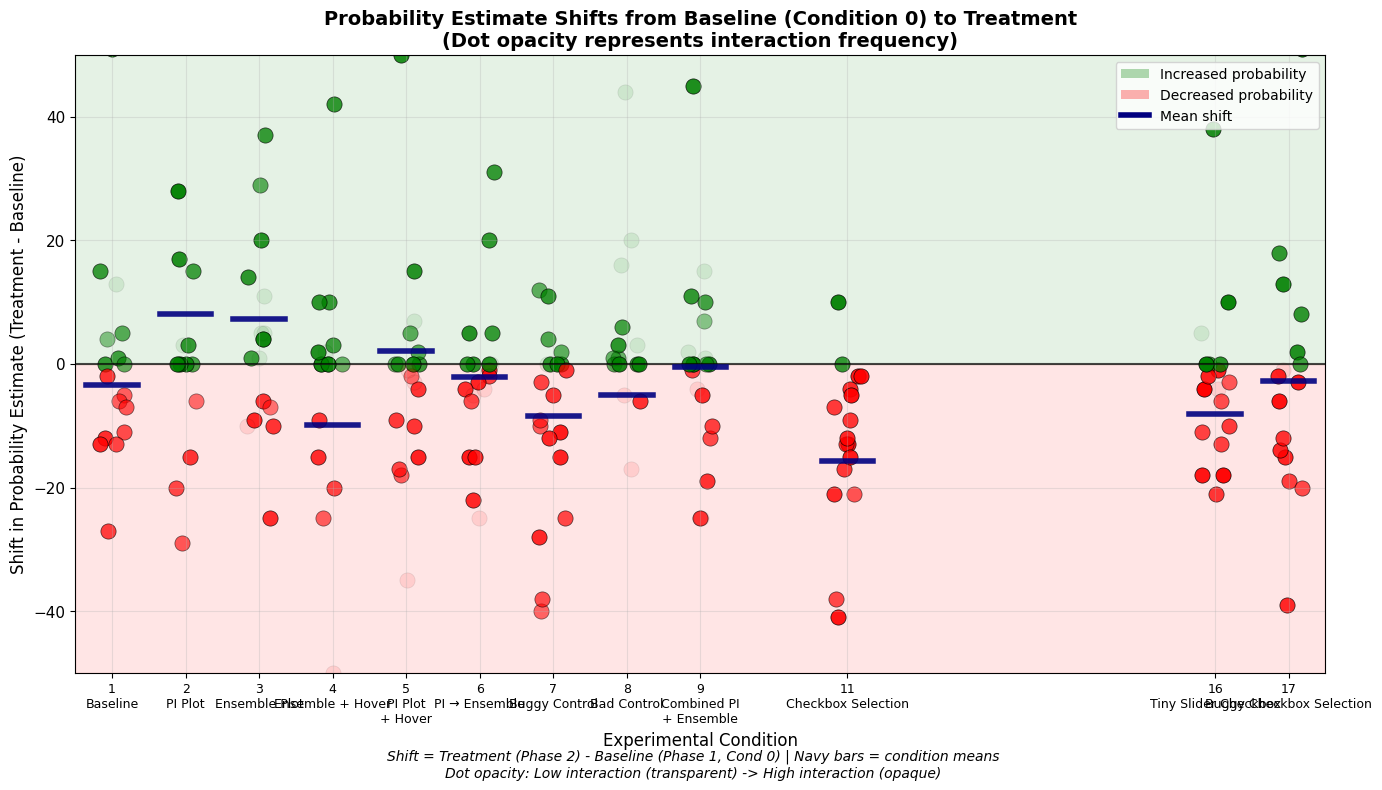

In [17]:
# Modified function to use interaction_freq for opacity instead of confidence
def create_probability_estimate_shift_plot_v2(phase1_data, phase2_data):
    """Create probability estimate shift plot from baseline (phase 1) to treatment (phase 2)."""

    condition_names = build_condition_lookup(phase2_data, include_historical=False)

    phase1_dict = {}
    for _, row in phase1_data.iterrows():
        if pd.notna(row.get('probability_estimate')):
            pid = row.get('participant_id', row.name)
            phase1_dict[pid] = row['probability_estimate']

    shift_data = []
    for _, row in phase2_data.iterrows():
        if pd.notna(row.get('probability_estimate')):
            pid = row.get('participant_id', row.name)
            cond_num = extract_condition_number(row.get('condition_id'))
            if cond_num is None or cond_num == 0 or pid not in phase1_dict:
                continue

            shift_data.append({
                'participant_id': pid,
                'condition_number': int(cond_num),
                'shift': row['probability_estimate'] - phase1_dict[pid],
                'interaction_freq': row.get('interaction_freq', 0)
            })

    if not shift_data:
        print("No matched data found for shift calculation")
        print(f"Phase 1 participants: {len(phase1_dict)}")
        print(f"Phase 2 rows: {len(phase2_data)}")
        return None

    shift_df = pd.DataFrame(shift_data)
    treatment_conditions = sorted(shift_df['condition_number'].unique())

    min_freq = shift_df['interaction_freq'].min()
    max_freq = shift_df['interaction_freq'].max()
    if max_freq > min_freq:
        shift_df['opacity'] = 0.1 + (shift_df['interaction_freq'] - min_freq) / (max_freq - min_freq) * 0.9
    else:
        shift_df['opacity'] = 0.7

    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axhspan(0, 50, alpha=0.1, color='green', label='Increased probability')
    ax.axhspan(-50, 0, alpha=0.1, color='red', label='Decreased probability')

    colors = ['green' if s >= 0 else 'red' for s in shift_df['shift']]
    np.random.seed(42)
    jitter = np.random.uniform(-0.2, 0.2, len(shift_df))
    x_positions = shift_df['condition_number'] + jitter

    for x, y, opacity, color in zip(x_positions, shift_df['shift'], shift_df['opacity'], colors):
        ax.scatter(x, y, alpha=opacity, s=120, c=color, edgecolors='black', linewidth=0.5)

    mean_shifts = shift_df.groupby('condition_number')['shift'].mean()
    for cond in treatment_conditions:
        ax.plot([cond - 0.35, cond + 0.35], [mean_shifts[cond], mean_shifts[cond]], color='navy', linewidth=4, alpha=0.9)

    ax.set_title('Probability Estimate Shifts from Baseline (Condition 0) to Treatment\n(Dot opacity represents interaction frequency)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel('Shift in Probability Estimate (Treatment - Baseline)', fontsize=12)
    ax.set_ylim(-50, 50)
    ax.set_xlim(min(treatment_conditions) - 0.5, max(treatment_conditions) + 0.5)
    ax.set_xticks(treatment_conditions)
    ax.grid(True, alpha=0.3, axis='y')

    labels = [f"{c}\n{wrap_condition_label(condition_names.get(c, f'Condition {c}'), max_words=3)}" for c in treatment_conditions]
    ax.set_xticklabels(labels, fontsize=9, ha='center')

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor='green', alpha=0.3, label='Increased probability'),
        Patch(facecolor='red', alpha=0.3, label='Decreased probability'),
        Line2D([0], [0], color='navy', linewidth=4, label='Mean shift')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

    fig.text(0.5, 0.02, 'Shift = Treatment (Phase 2) - Baseline (Phase 1, Cond 0) | Navy bars = condition means\nDot opacity: Low interaction (transparent) -> High interaction (opaque)', ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)

    print("\nProbability Estimate Shift Summary:")
    print(f"Participants with matched baseline: {len(shift_df)}")
    print(f"Interaction frequency range: {min_freq} - {max_freq}")
    print("\nMean shift by condition (from Condition 0 baseline):")
    print("-" * 60)

    for cond in treatment_conditions:
        cond_data = shift_df[shift_df['condition_number'] == cond]
        mean = cond_data['shift'].mean()
        std = cond_data['shift'].std()
        n = len(cond_data)
        direction = '↑' if mean > 0 else '↓' if mean < 0 else '→'
        cond_name = condition_names.get(cond, f'Condition {cond}')
        print(f"  Condition {cond} ({cond_name}): {direction} {mean:+.2f} (SD={std:.2f}, n={n})")

    plt.show()
    return shift_df

# Test the new function
shift_summary_prob_v2 = create_probability_estimate_shift_plot_v2(phase1_data, phase2_data)



Confidence Rating Shift Summary:
Participants with matched baseline: 226
Interaction frequency range: 0.6931471805599453 - 13.625012060930079

Mean shift by condition (from Condition 0 baseline):
------------------------------------------------------------
  Condition 1 (Baseline): ↑ +0.61 (SD=1.50, n=18)
  Condition 2 (PI Plot): ↑ +1.11 (SD=1.41, n=18)
  Condition 3 (Ensemble Plot): ↑ +0.17 (SD=1.29, n=18)
  Condition 4 (Ensemble + Hover): ↑ +0.11 (SD=1.73, n=19)
  Condition 5 (PI Plot + Hover): ↑ +0.86 (SD=1.46, n=21)
  Condition 6 (PI → Ensemble): → +0.00 (SD=1.00, n=19)
  Condition 7 (Buggy Control): ↑ +0.60 (SD=1.19, n=20)
  Condition 8 (Bad Control): ↑ +0.17 (SD=0.38, n=18)
  Condition 9 (Combined PI + Ensemble): ↑ +0.60 (SD=1.31, n=20)
  Condition 11 (Checkbox Selection): ↑ +0.56 (SD=1.25, n=18)
  Condition 16 (Tiny Slider Checkbox): ↑ +0.42 (SD=0.61, n=19)
  Condition 17 (Buggy Checkbox Selection): ↑ +0.22 (SD=1.06, n=18)


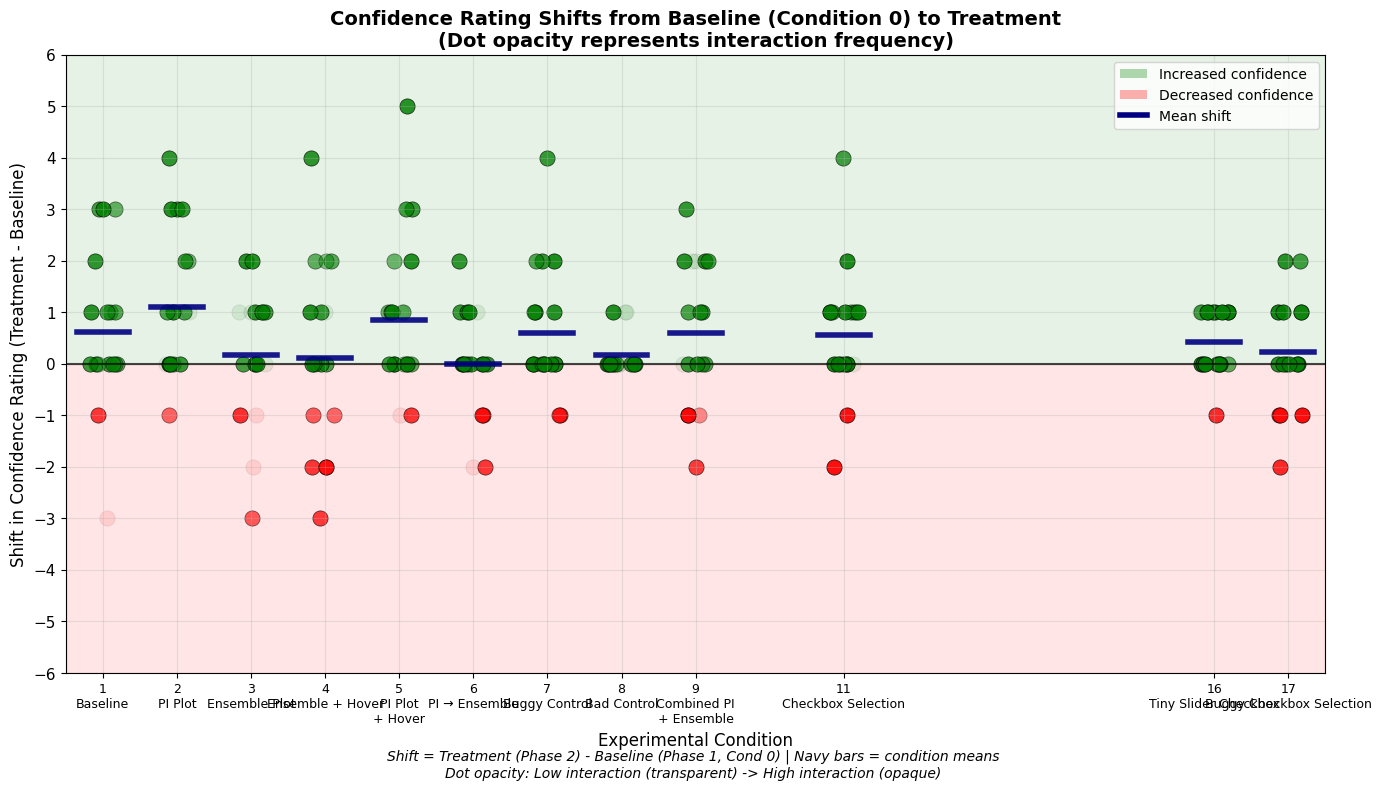

In [18]:
# Modified function to use interaction_freq for opacity instead of fixed alpha
def create_confidence_shift_plot_v2(phase1_data, phase2_data):
    """Create confidence-rating shift plot from baseline (phase 1) to treatment (phase 2)."""

    condition_names = build_condition_lookup(phase2_data, include_historical=False)

    phase1_dict = {}
    for _, row in phase1_data.iterrows():
        if pd.notna(row.get('confidence_rating')):
            pid = row.get('participant_id', row.name)
            phase1_dict[pid] = row['confidence_rating']

    shift_data = []
    for _, row in phase2_data.iterrows():
        if pd.notna(row.get('confidence_rating')):
            pid = row.get('participant_id', row.name)
            cond_num = extract_condition_number(row.get('condition_id'))
            if cond_num is None or cond_num == 0 or pid not in phase1_dict:
                continue

            shift_data.append({
                'participant_id': pid,
                'condition_number': int(cond_num),
                'shift': row['confidence_rating'] - phase1_dict[pid],
                'interaction_freq': row.get('interaction_freq', 0)
            })

    if not shift_data:
        print("No matched data found for shift calculation")
        print(f"Phase 1 participants: {len(phase1_dict)}")
        print(f"Phase 2 rows: {len(phase2_data)}")
        return None

    shift_df = pd.DataFrame(shift_data)
    treatment_conditions = sorted(shift_df['condition_number'].unique())

    min_freq = shift_df['interaction_freq'].min()
    max_freq = shift_df['interaction_freq'].max()
    if max_freq > min_freq:
        shift_df['opacity'] = 0.1 + (shift_df['interaction_freq'] - min_freq) / (max_freq - min_freq) * 0.9
    else:
        shift_df['opacity'] = 0.7

    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axhspan(0, 6, alpha=0.1, color='green', label='Increased confidence')
    ax.axhspan(-6, 0, alpha=0.1, color='red', label='Decreased confidence')

    colors = ['green' if s >= 0 else 'red' for s in shift_df['shift']]
    np.random.seed(42)
    jitter = np.random.uniform(-0.2, 0.2, len(shift_df))
    x_positions = shift_df['condition_number'] + jitter

    for x, y, opacity, color in zip(x_positions, shift_df['shift'], shift_df['opacity'], colors):
        ax.scatter(x, y, alpha=opacity, s=120, c=color, edgecolors='black', linewidth=0.5)

    mean_shifts = shift_df.groupby('condition_number')['shift'].mean()
    for cond in treatment_conditions:
        ax.plot([cond - 0.35, cond + 0.35], [mean_shifts[cond], mean_shifts[cond]], color='navy', linewidth=4, alpha=0.9)

    ax.set_title('Confidence Rating Shifts from Baseline (Condition 0) to Treatment\n(Dot opacity represents interaction frequency)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel('Shift in Confidence Rating (Treatment - Baseline)', fontsize=12)
    ax.set_ylim(-6, 6)
    ax.set_xlim(min(treatment_conditions) - 0.5, max(treatment_conditions) + 0.5)
    ax.set_xticks(treatment_conditions)
    ax.set_yticks(range(-6, 7))
    ax.grid(True, alpha=0.3, axis='y')

    labels = [f"{c}\n{wrap_condition_label(condition_names.get(c, f'Condition {c}'), max_words=3)}" for c in treatment_conditions]
    ax.set_xticklabels(labels, fontsize=9, ha='center')

    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Patch(facecolor='green', alpha=0.3, label='Increased confidence'),
        Patch(facecolor='red', alpha=0.3, label='Decreased confidence'),
        Line2D([0], [0], color='navy', linewidth=4, label='Mean shift')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

    fig.text(0.5, 0.02, 'Shift = Treatment (Phase 2) - Baseline (Phase 1, Cond 0) | Navy bars = condition means\nDot opacity: Low interaction (transparent) -> High interaction (opaque)', ha='center', fontsize=10, style='italic')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)

    print("\nConfidence Rating Shift Summary:")
    print(f"Participants with matched baseline: {len(shift_df)}")
    print(f"Interaction frequency range: {min_freq} - {max_freq}")
    print("\nMean shift by condition (from Condition 0 baseline):")
    print("-" * 60)

    for cond in treatment_conditions:
        cond_data = shift_df[shift_df['condition_number'] == cond]
        mean = cond_data['shift'].mean()
        std = cond_data['shift'].std()
        n = len(cond_data)
        direction = '↑' if mean > 0 else '↓' if mean < 0 else '→'
        cond_name = condition_names.get(cond, f'Condition {cond}')
        print(f"  Condition {cond} ({cond_name}): {direction} {mean:+.2f} (SD={std:.2f}, n={n})")

    plt.show()
    return shift_df

# Test the new function
shift_summary_v2 = create_confidence_shift_plot_v2(phase1_data, phase2_data)


### Trust and Usability Measures by Condition

In [19]:
# Define question structures for each survey type

interactionQuestions = [
	{
		"prompt": "I was in control of my navigation through this interface.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "navigation_control"
	},
	{
		"prompt": "I had some control over the content of this interface that I wanted to see.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "content_control"
	},
	{
		"prompt": "I was in control over the pace of my visit to this interface.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "pace_control"
	},
	{
		"prompt": "I could communicate with the company directly for further questions about the company or its products if I wanted to.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "company_communication"
	},
	{
		"prompt": "The interface had the ability to respond to my specific questions quickly and efficiently.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "interface_responsiveness"
	},
	{
		"prompt": "I could communicate in real time with other customers who shared my interest in this interface.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "customer_communication"
	},
	{
		"prompt": "I felt I just had a personal conversation with a sociable, knowledgeable and warm representative from the company.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "personal_conversation"
	},
	{
		"prompt": "The interface was like talking back to me while I clicked through the interface.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "interface_interaction"
	},
	{
		"prompt": "I perceived the interface to be sensitive to my needs for product information.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "interface_sensitivity"
	}
]

visualizationTrustQuestions = [
	{
		"prompt": "I was skeptical about the information presented in this visualization.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "skeptical_rating"
	},
	{
		"prompt": "I trusted this data.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "data_trust"
	},
	{
		"prompt": "I found this visualization difficult to use.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "usability_difficulty"
	},
	{
		"prompt": "I found this visualization easy to understand.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "comprehension_ease"
	}
]

personalityQuestions = [
	{
		"prompt": "I respect others.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "respect_others"
	},
	{
		"prompt": "I have a good word for everyone.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "good_word_everyone"
	},
	{
		"prompt": "I retreat from others.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "retreat_from_others"
	},
	{
		"prompt": "I avoid contacts with others.",
		"labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
				   "Slightly Agree", "Agree", "Strongly Agree"],
		"type": "avoid_contacts"
	}
]

## 4. Trust and Usability Visualizations

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

def create_sectioned_trust_plots(data, condition_names, questions, section_title="Survey Results"):
    """
    Create figures with subplots for all questions in the provided question list.
    Each subplot shows ratings by condition for that question.
    """
    if not questions:
        print(f"No questions provided for {section_title}")
        return

    observed_conditions = sorted({
        c for c in data['condition_id'].dropna().map(extract_condition_number).tolist()
        if c is not None and c != 0
    })

    if not observed_conditions:
        print(f"No treatment conditions found for {section_title}")
        return

    n = len(questions)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(16, 4*n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, q in zip(axes, questions):
        measure_key = q["type"]
        measure_name = q["prompt"]

        measure_data = data[pd.notna(data.get(measure_key)) & pd.notna(data["condition_id"])].copy()

        values, cond_nums = [], []
        for _, row in measure_data.iterrows():
            cond_num = extract_condition_number(row["condition_id"])
            if cond_num is None or cond_num == 0:
                continue
            values.append(row[measure_key])
            cond_nums.append(cond_num)

        if values:
            ax.scatter(cond_nums, values, alpha=0.7, s=120, edgecolors='black', color="#1f77b4")
            df_plot = pd.DataFrame({"cond": cond_nums, "val": values})
            cond_means = df_plot.groupby("cond")["val"].mean()
            for c, mean_val in cond_means.items():
                ax.plot([c-0.3, c+0.3], [mean_val, mean_val], "r-", linewidth=3, alpha=0.8)

        ax.set_title(measure_name, fontsize=12, fontweight="bold", wrap=True)
        ax.set_ylim(-0.5, 6.5)
        ax.set_xlim(min(observed_conditions) - 0.5, max(observed_conditions) + 0.5)
        ax.set_xticks(observed_conditions)

        labels = []
        for cond in observed_conditions:
            name = condition_names.get(cond, f"Condition {cond}")
            labels.append(f"{cond}\n{wrap_condition_label(name, max_words=3)}")
        ax.set_xticklabels(labels, fontsize=9)

        ax.set_xlabel("Experimental Condition", fontsize=10)
        ax.set_ylabel("Rating (0-6)", fontsize=10)
        ax.grid(True, alpha=0.3)

    fig.suptitle(section_title, fontsize=16, fontweight="bold", y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


In [21]:
# Extract survey responses from JSON response column
import json

def extract_survey_responses(data):
	"""Extract survey responses from the JSON response column and add as individual columns"""
	data_copy = data.copy()
	
	for idx, row in data_copy.iterrows():
		if 'response' in row and pd.notna(row['response']):
			try:
				# Parse the JSON response data
				response_data = json.loads(row['response'])
				
				# Add each response as a new column
				for key, value in response_data.items():
					data_copy.at[idx, key] = value
					
			except Exception as e:
				print(f"Error parsing response for row {idx}: {e}")
	
	return data_copy

print("=== EXTRACTING SURVEY RESPONSE DATA ===")

# Extract responses for each dataset
print("Extracting interaction data responses...")
interaction_data_expanded = extract_survey_responses(interaction_data)

print("Extracting trust data responses...")  
trust_data_expanded = extract_survey_responses(trust_data)

print("Extracting demographics data responses...")
demographics_data_expanded = extract_survey_responses(demographics_data)

# Check what columns are now available
print(f"\n=== AFTER EXTRACTION ===")
print(f"Interaction data shape: {interaction_data_expanded.shape}")
print("Interaction data columns:")
interaction_cols = [col for col in interaction_data_expanded.columns if col in ['navigation_control', 'content_control', 'pace_control', 'company_communication', 'interface_responsiveness', 'customer_communication', 'personal_conversation', 'interface_interaction', 'interface_sensitivity']]
print(interaction_cols)

print(f"\nTrust data shape: {trust_data_expanded.shape}")
print("Trust data columns:")
trust_cols = [col for col in trust_data_expanded.columns if col in ['skeptical_rating', 'data_trust', 'usability_difficulty', 'comprehension_ease']]
print(trust_cols)

print(f"\nDemographics data shape: {demographics_data_expanded.shape}")
print("Demographics data columns:")
demo_cols = [col for col in demographics_data_expanded.columns if col in ['respect_others', 'good_word_everyone', 'retreat_from_others', 'avoid_contacts']]
print(demo_cols)

# Update the global variables to use the expanded data
interaction_data = interaction_data_expanded
trust_data = trust_data_expanded
demographics_data = demographics_data_expanded

=== EXTRACTING SURVEY RESPONSE DATA ===
Extracting interaction data responses...
Extracting trust data responses...
Extracting demographics data responses...

=== AFTER EXTRACTION ===
Interaction data shape: (226, 65)
Interaction data columns:
['navigation_control', 'content_control', 'pace_control', 'company_communication', 'interface_responsiveness', 'customer_communication', 'personal_conversation', 'interface_interaction', 'interface_sensitivity']

Trust data shape: (226, 56)
Trust data columns:
['comprehension_ease', 'data_trust', 'skeptical_rating', 'usability_difficulty']

Demographics data shape: (226, 59)
Demographics data columns:
['respect_others', 'good_word_everyone', 'retreat_from_others', 'avoid_contacts']



Creating visualization for trust/usability data...


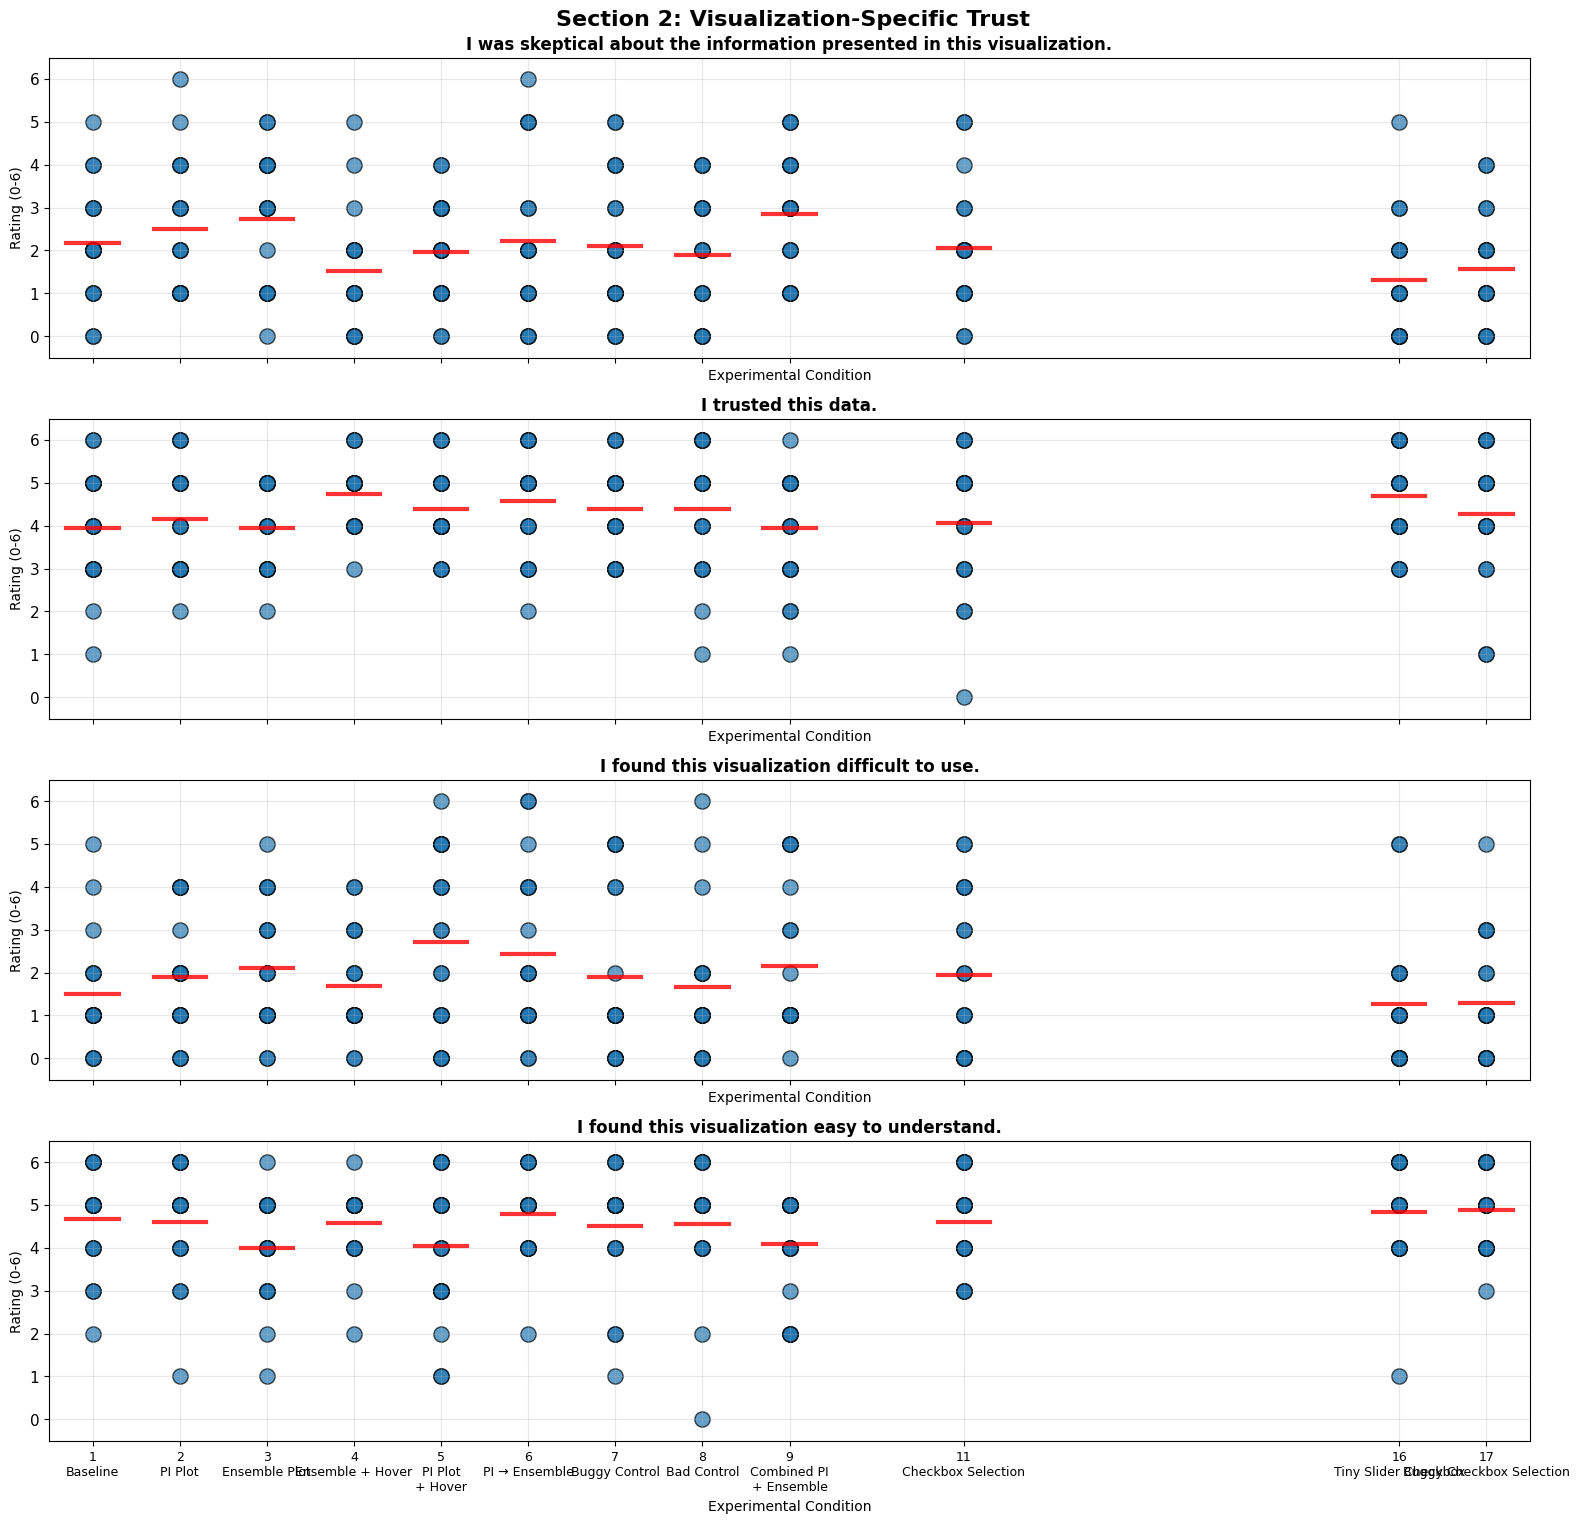

In [22]:
# Generate three separate visualizations for each data type
condition_names = build_condition_lookup(relevant_trials, include_historical=True)

# # Create visualization for interaction data
# print("Creating visualization for interface interaction data...")
# create_sectioned_trust_plots(
#     data=interaction_data,
#     condition_names=condition_names,
#     questions=interactionQuestions,
#     section_title="Section 1: Interface Interaction & Control"
# )

# Create visualization for trust data
print("\nCreating visualization for trust/usability data...")
create_sectioned_trust_plots(
    data=trust_data,
    condition_names=condition_names,
    questions=visualizationTrustQuestions,
    section_title="Section 2: Visualization-Specific Trust"
)


In [23]:
def make_heatmap(df, question_cols, title):
	# Keep only the columns we want
	sub = df[['participant_id'] + question_cols].set_index('participant_id')

	# Convert values to numeric
	sub = sub.apply(pd.to_numeric, errors='coerce')

	plt.figure(figsize=(12, 6))
	plt.imshow(sub, aspect='auto', cmap='hot', vmin=-1, vmax=8)

	plt.colorbar(label="Response (1 = light, 7 = dark)")
	plt.title(title)

	# Tick labels
	plt.xticks(
		ticks=np.arange(len(question_cols)),
		labels=question_cols,
		rotation=90
	)
	plt.yticks(
		ticks=np.arange(len(sub.index)),
		labels=sub.index
	)

	plt.tight_layout()
	plt.show()

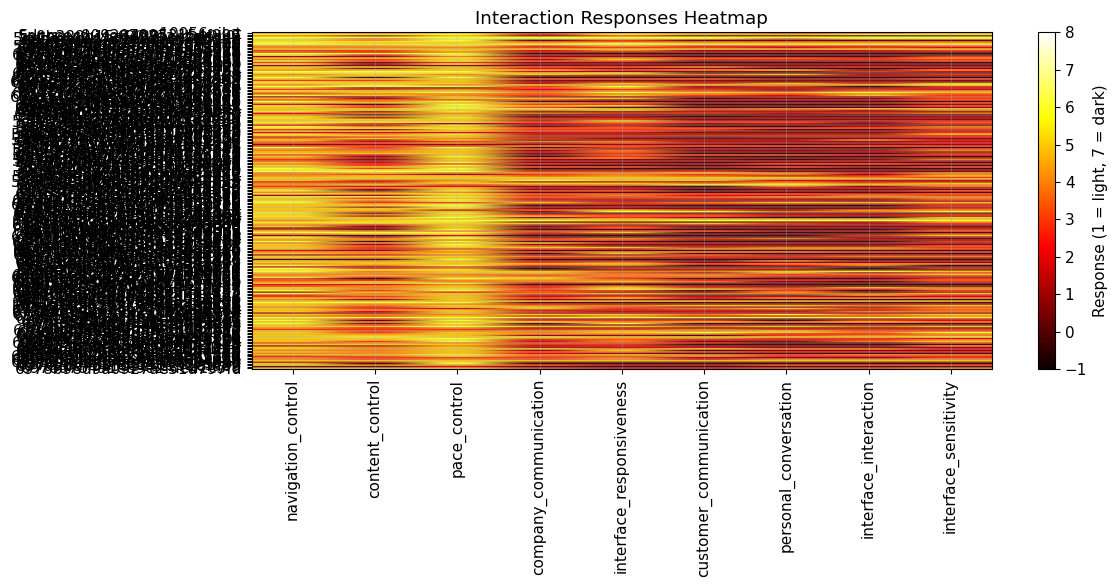

In [24]:
make_heatmap(
	interaction_data,
	interaction_cols,
	"Interaction Responses Heatmap"
)

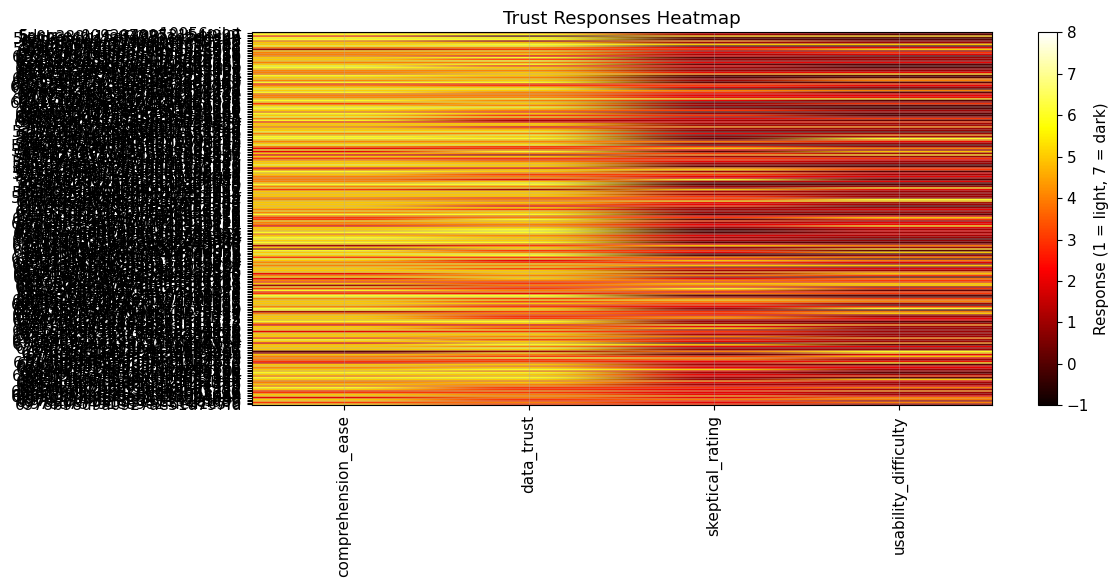

In [25]:
make_heatmap(
	trust_data,
	trust_cols,
	"Trust Responses Heatmap"
)

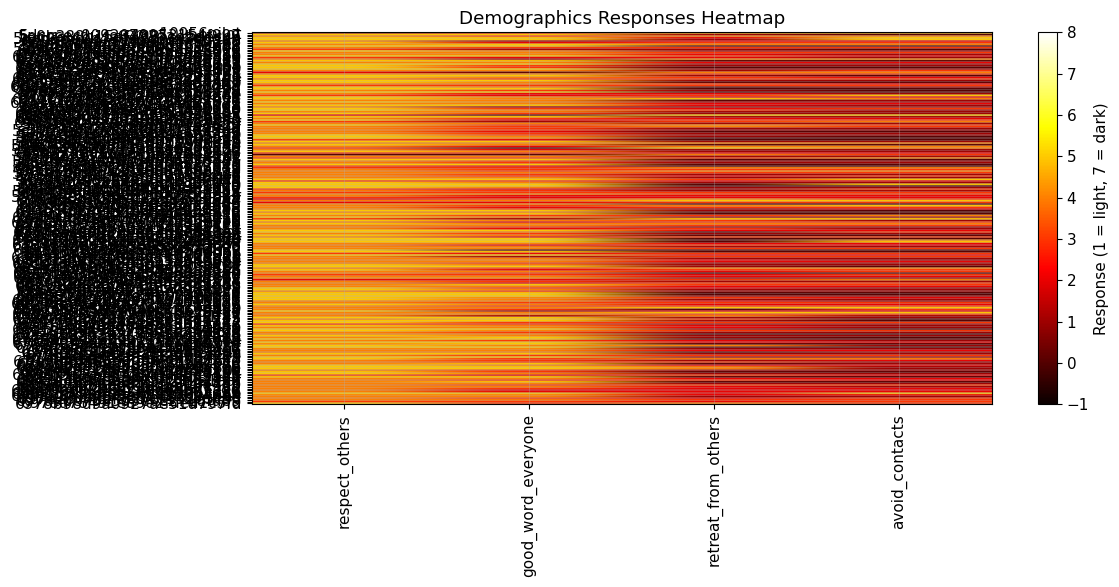

In [26]:
make_heatmap(
	demographics_data,
	demo_cols,
	"Demographics Responses Heatmap"
)

In [27]:
# Calculate averaged interaction scores by condition
import numpy as np
from scipy import stats

interaction_cols = ['navigation_control', 'content_control', 'pace_control',
                   'company_communication', 'interface_responsiveness',
                   'customer_communication', 'personal_conversation',
                   'interface_interaction', 'interface_sensitivity']

print("=== INTERACTION SCORES BY CONDITION ===")
print("\nCalculating averaged interaction scores (1-7 scale)...")

interaction_results = []

for _, row in interaction_data.iterrows():
    condition_id = row.get('condition_id')
    condition_name = row.get('condition_name')
    condition_num = extract_condition_number(condition_id)

    if condition_num is None or condition_num == 0:
        continue

    scores = []
    for col in interaction_cols:
        if col in row and pd.notna(row[col]):
            scores.append(row[col])

    if scores:
        interaction_results.append({
            'condition_id': condition_id,
            'condition_num': int(condition_num),
            'condition_name': condition_name,
            'participant_id': row['participant_id'],
            'avg_interaction_score': np.mean(scores),
            'num_questions': len(scores)
        })

results_df = pd.DataFrame(interaction_results)

if len(results_df) > 0:
    condition_stats = results_df.groupby('condition_num').agg({
        'avg_interaction_score': ['mean', 'std', 'count'],
        'condition_id': 'first'
    }).round(3)

    condition_stats.columns = ['mean_score', 'std_score', 'n_participants', 'condition_id']
    condition_stats['se_score'] = (condition_stats['std_score'] / np.sqrt(condition_stats['n_participants'])).round(3)

    condition_name_lookup = build_condition_lookup(results_df[['condition_id', 'condition_name']], include_historical=False)
    condition_stats['condition_name'] = condition_stats.index.map(lambda c: condition_name_lookup.get(c, f'Condition {c}'))

    condition_stats_ranked = condition_stats.sort_values('mean_score', ascending=False)

    print("\n=== INTERACTION SCORES RANKED BY CONDITION (High to Low) ===")
    print("Format: Condition | Mean ± SE | (n participants)")
    print("-" * 65)

    for rank, (condition_num, row) in enumerate(condition_stats_ranked.iterrows(), 1):
        condition_name = row['condition_name']
        mean_score = row['mean_score']
        se_score = row['se_score']
        n = int(row['n_participants'])

        print(f"{rank:2d}. Condition {condition_num} ({condition_name:24s}) | {mean_score:.2f} ± {se_score:.2f} | (n={n})")

    print("\n=== DETAILED STATISTICS ===")
    display_cols = ['condition_name', 'mean_score', 'std_score', 'se_score', 'n_participants']
    detailed_stats = condition_stats_ranked[display_cols].copy()
    detailed_stats.index.name = 'Condition'
    print(detailed_stats.to_string())

    print("\n=== INDIVIDUAL PARTICIPANT SCORES ===")
    for condition_num in sorted(condition_stats_ranked.index):
        condition_name = condition_name_lookup.get(condition_num, f"Condition {condition_num}")
        participant_scores = results_df[results_df['condition_num'] == condition_num]['avg_interaction_score'].tolist()
        print(f"Condition {condition_num} ({condition_name}): {participant_scores}")

else:
    print("No interaction data found for analysis")


=== INTERACTION SCORES BY CONDITION ===

Calculating averaged interaction scores (1-7 scale)...

=== INTERACTION SCORES RANKED BY CONDITION (High to Low) ===
Format: Condition | Mean ± SE | (n participants)
-----------------------------------------------------------------
 1. Condition 16 (Tiny Slider Checkbox    ) | 3.23 ± 0.32 | (n=19)
 2. Condition 9 (Combined PI + Ensemble  ) | 3.09 ± 0.25 | (n=20)
 3. Condition 6 (PI → Ensemble           ) | 3.08 ± 0.35 | (n=19)
 4. Condition 11 (Checkbox Selection      ) | 3.02 ± 0.34 | (n=18)
 5. Condition 7 (Buggy Control           ) | 3.02 ± 0.28 | (n=20)
 6. Condition 4 (Ensemble + Hover        ) | 2.95 ± 0.19 | (n=19)
 7. Condition 17 (Buggy Checkbox Selection) | 2.90 ± 0.32 | (n=18)
 8. Condition 8 (Bad Control             ) | 2.72 ± 0.23 | (n=18)
 9. Condition 2 (PI Plot                 ) | 2.65 ± 0.33 | (n=18)
10. Condition 3 (Ensemble Plot           ) | 2.60 ± 0.23 | (n=18)
11. Condition 1 (Baseline                ) | 2.53 ± 0.26 | (n=18

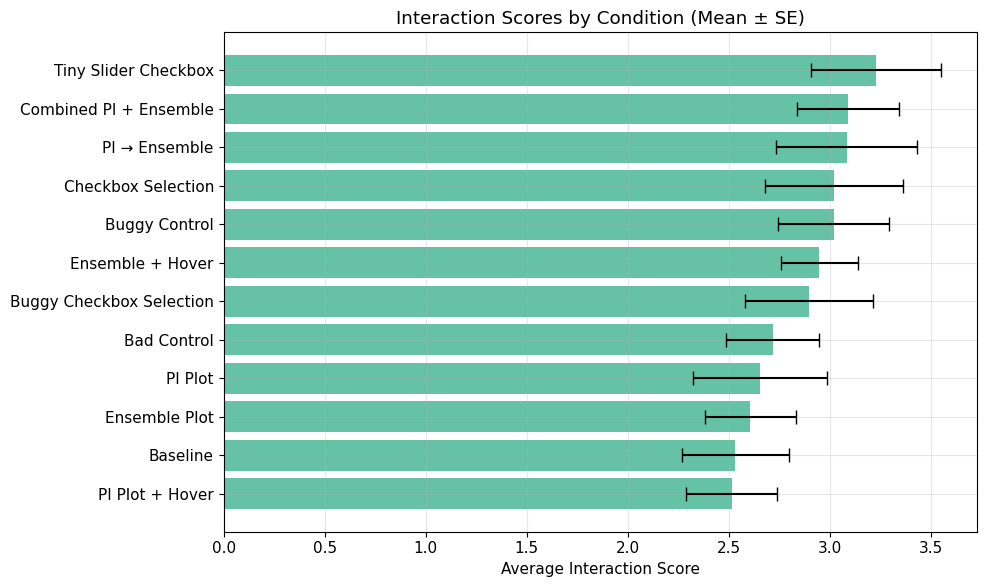

In [28]:

# --- Sort conditions by mean score (high → low) ---
condition_stats_sorted = condition_stats.sort_values("mean_score", ascending=False)

# Extract plotting data
labels = condition_stats_sorted['condition_name'].tolist()
means = condition_stats_sorted['mean_score'].tolist()
errors = condition_stats_sorted['se_score'].tolist()

plt.figure(figsize=(10, 6))

# Horizontal bar chart with error bars
plt.barh(range(len(labels)), means, xerr=errors, capsize=5)
plt.gca().invert_yaxis()  # Highest score at top

plt.yticks(range(len(labels)), labels)
plt.xlabel("Average Interaction Score")
plt.title("Interaction Scores by Condition (Mean ± SE)")

plt.tight_layout()
plt.show()

Composite Trust Score Analysis
Averaging across 4 trust questions:
1. skeptical_rating [REVERSED]
2. data_trust
3. usability_difficulty [REVERSED]
4. trust_composite
Using columns: ['skeptical_rating', 'data_trust', 'usability_difficulty', 'trust_composite']


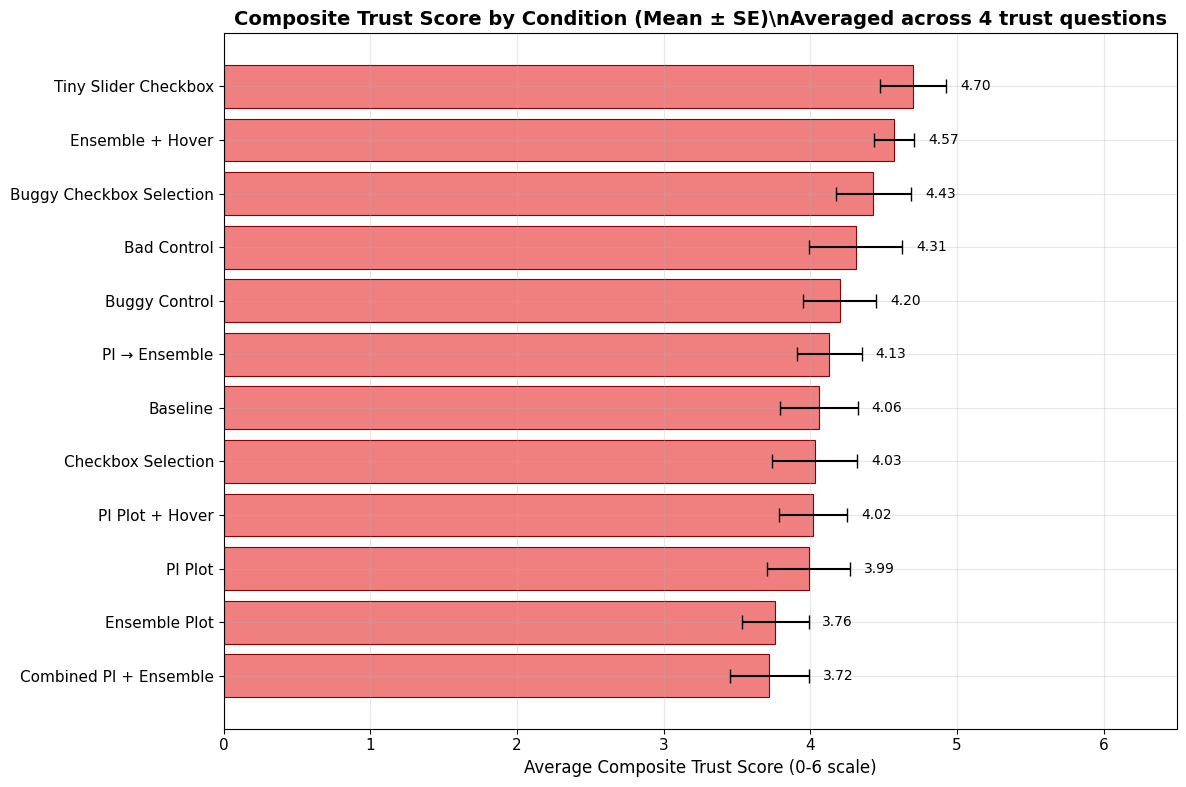

\nComposite Trust Score by Condition:
Tiny Slider Checkbox: 4.70 ± 0.23 (n=19)
Ensemble + Hover: 4.57 ± 0.14 (n=19)
Buggy Checkbox Selection: 4.43 ± 0.26 (n=18)
Bad Control: 4.31 ± 0.32 (n=18)
Buggy Control: 4.20 ± 0.25 (n=20)
PI → Ensemble: 4.13 ± 0.22 (n=19)
Baseline: 4.06 ± 0.26 (n=18)
Checkbox Selection: 4.03 ± 0.29 (n=18)
PI Plot + Hover: 4.02 ± 0.23 (n=21)
PI Plot: 3.99 ± 0.28 (n=18)
Ensemble Plot: 3.76 ± 0.23 (n=18)
Combined PI + Ensemble: 3.72 ± 0.27 (n=20)


In [29]:
# Create composite trust score averaging across 4 questions with score reversal
def analyze_composite_trust_score(data):
	"""
	Create a composite trust score by averaging across 4 trust questions.
	Questions 1 and 3 (skeptical_rating and usability_difficulty) are reversed.
	
	Parameters:
	- data: DataFrame with trust survey responses
	"""
	
	# Define the 4 trust questions
	trust_columns = ['skeptical_rating', 'data_trust', 'usability_difficulty', 'trust_composite']
	reverse_columns = ['skeptical_rating', 'usability_difficulty']  # Questions 1 and 3 to flip
	
	print("Composite Trust Score Analysis")
	print("=" * 50)
	print("Averaging across 4 trust questions:")
	print("1. skeptical_rating [REVERSED]")
	print("2. data_trust") 
	print("3. usability_difficulty [REVERSED]")
	print("4. trust_composite")
	print("=" * 50)
	
	# Filter for valid conditions
	valid_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	
	# Check which columns exist
	available_columns = [col for col in trust_columns if col in valid_data.columns]
	missing_columns = [col for col in trust_columns if col not in valid_data.columns]
	
	if missing_columns:
		print(f"Warning: Missing columns: {missing_columns}")
	
	if len(available_columns) == 0:
		print("No trust columns found in data")
		return None
	
	print(f"Using columns: {available_columns}")
	
	# Create reversed scores for specified columns
	for col in available_columns:
		if col in reverse_columns:
			valid_data[f'{col}_rev'] = 6 - valid_data[col]
		else:
			valid_data[f'{col}_rev'] = valid_data[col]
	
	# Calculate composite trust score (average across available questions)
	reversed_columns = [f'{col}_rev' for col in available_columns]
	valid_data['composite_trust_score'] = valid_data[reversed_columns].mean(axis=1, skipna=True)
	
	# Filter for participants with composite scores
	trust_data = valid_data[valid_data['composite_trust_score'].notna()].copy()
	
	if len(trust_data) == 0:
		print("No valid composite trust scores calculated")
		return None
	
	# Calculate statistics by condition
	condition_stats = trust_data.groupby(['condition_id', 'condition_name']).agg({
		'composite_trust_score': ['mean', 'std', 'count']
	}).round(2)
	
	# Flatten column names
	condition_stats.columns = ['mean_score', 'std_score', 'n_score']
	condition_stats = condition_stats.reset_index()
	
	# Calculate standard error
	condition_stats['se_score'] = condition_stats['std_score'] / np.sqrt(condition_stats['n_score'])
	
	# --- Sort conditions by mean score (high → low) ---
	condition_stats_sorted = condition_stats.sort_values("mean_score", ascending=False)
	
	# Extract plotting data
	labels = condition_stats_sorted['condition_name'].tolist()
	means = condition_stats_sorted['mean_score'].tolist()
	errors = condition_stats_sorted['se_score'].tolist()
	
	plt.figure(figsize=(12, 8))
	
	# Horizontal bar chart with error bars
	bars = plt.barh(range(len(labels)), means, xerr=errors, capsize=5, 
					color='lightcoral', edgecolor='darkred', linewidth=0.8)
	plt.gca().invert_yaxis()  # Highest score at top
	
	plt.yticks(range(len(labels)), labels)
	plt.xlabel("Average Composite Trust Score (0-6 scale)", fontsize=12)
	plt.title("Composite Trust Score by Condition (Mean ± SE)\\nAveraged across 4 trust questions", fontsize=14, fontweight='bold')
	
	# Add value labels on bars
	for i, (mean, se) in enumerate(zip(means, errors)):
		plt.text(mean + se + max(means) * 0.02, i, f'{mean:.2f}', 
				va='center', fontsize=10)
	
	# Add grid for better readability
	plt.grid(axis='x', alpha=0.3)
	plt.xlim(0, 6.5)
	
	plt.tight_layout()
	plt.show()
	
	# Print analysis table
	print(f"\\nComposite Trust Score by Condition:")
	print("=" * 60)
	for _, row in condition_stats_sorted.iterrows():
		print(f"{row['condition_name']}: {row['mean_score']:.2f} ± {row['se_score']:.2f} (n={row['n_score']})")
	
	return condition_stats_sorted

# Run the composite trust analysis
composite_trust_results = analyze_composite_trust_score(relevant_trials)

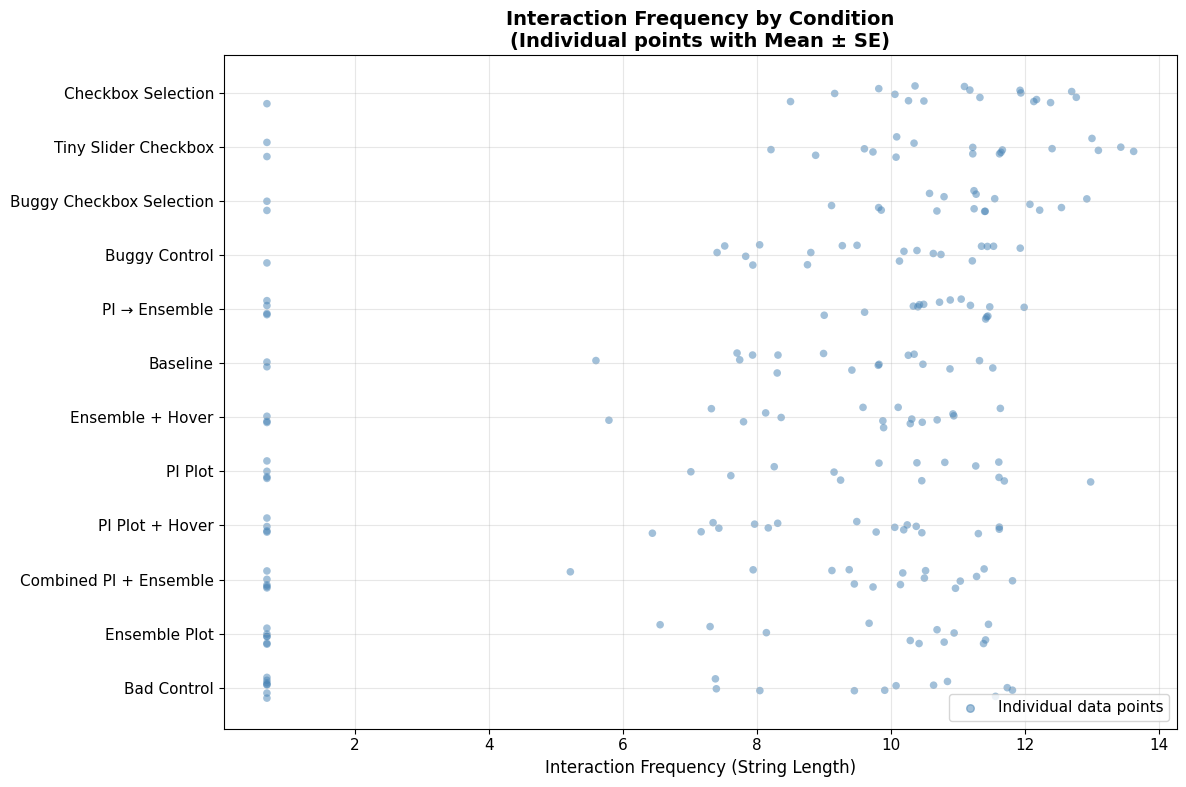


Interaction Frequency by Condition Summary:
Checkbox Selection: 10.5 ± 0.6 (n=18)
Tiny Slider Checkbox: 10.1 ± 0.8 (n=19)
Buggy Checkbox Selection: 10.0 ± 0.8 (n=18)
Buggy Control: 9.3 ± 0.6 (n=20)
PI → Ensemble: 8.7 ± 1.0 (n=19)
Baseline: 8.3 ± 0.7 (n=18)
Ensemble + Hover: 8.1 ± 0.8 (n=19)
PI Plot: 8.0 ± 1.0 (n=18)
PI Plot + Hover: 7.7 ± 0.8 (n=21)
Combined PI + Ensemble: 7.6 ± 1.0 (n=20)
Ensemble Plot: 6.8 ± 1.1 (n=18)
Bad Control: 6.3 ± 1.1 (n=18)


In [30]:
# Create horizontal dot plot for interaction frequency by condition
def create_interaction_freq_dot_plot(data):
	"""
	Create a horizontal dot plot showing interaction frequency by condition.
	Each dot represents one data point.
	
	Parameters:
	- data: DataFrame with columns: condition_id, condition_name, interaction_freq
	"""
	# import matplotlib.pyplot as plt
	# import pandas as pd
	# import numpy as np
	
	# Filter for valid conditions (exclude unknown and condition_0_historical)
	valid_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical'])) &
		(data['interaction_freq'].notna())
	].copy()

	if len(valid_data) == 0:
		print("No valid interaction frequency data found")
		return None
	
	# Calculate statistics by condition for summary and ordering
	condition_stats = valid_data.groupby(['condition_id', 'condition_name']).agg({
		'interaction_freq': ['mean', 'std', 'count']
	}).round(2)
	
	# Flatten column names
	condition_stats.columns = ['mean_freq', 'std_freq', 'n_freq']
	condition_stats = condition_stats.reset_index()
	
	# Calculate standard error
	condition_stats['se_freq'] = condition_stats['std_freq'] / np.sqrt(condition_stats['n_freq'])
	
	# --- Sort conditions by mean interaction frequency (high → low) ---
	condition_stats_sorted = condition_stats.sort_values("mean_freq", ascending=False)
	
	# Create ordered condition list for y-axis
	ordered_conditions = condition_stats_sorted['condition_name'].tolist()
	
	# Map condition names to y positions
	condition_to_y = {cond: i for i, cond in enumerate(ordered_conditions)}
	
	plt.figure(figsize=(12, 8))
	
	# Plot each data point as a dot with jitter
	for _, row in valid_data.iterrows():
		cond_name = row['condition_name']
		if cond_name in condition_to_y:
			y_pos = condition_to_y[cond_name]
			# Add small random jitter to y position to avoid overplotting
			y_jittered = y_pos + np.random.uniform(-0.2, 0.2)
			plt.scatter(row['interaction_freq'], y_jittered, 
					   alpha=0.5, color='steelblue', s=30, edgecolor='none')
	
	# # Add mean markers with error bars
	# for _, row in condition_stats_sorted.iterrows():
	#     y_pos = condition_to_y[row['condition_name']]
	#     plt.errorbar(row['mean_freq'], y_pos, xerr=row['se_freq'], 
	#                 fmt='D', color='darkred', markersize=8, capsize=5, 
	#                 capthick=2, elinewidth=2, zorder=5)
	
	plt.gca().invert_yaxis()  # Highest frequency at top
	
	plt.yticks(range(len(ordered_conditions)), ordered_conditions)
	plt.xlabel("Interaction Frequency (String Length)", fontsize=12)
	plt.title("Interaction Frequency by Condition\n(Individual points with Mean ± SE)", fontsize=14, fontweight='bold')
	
	# Add grid for better readability
	plt.grid(axis='x', alpha=0.3)
	
	# Add legend
	plt.scatter([], [], alpha=0.5, color='steelblue', s=30, label='Individual data points')
	# plt.errorbar([], [], xerr=[], fmt='D', color='darkred', markersize=8, 
	#             capsize=5, label='Mean ± SE')
	plt.legend(loc='lower right')
	
	plt.tight_layout()
	plt.show()
	
	# Print summary statistics
	print(f"\nInteraction Frequency by Condition Summary:")
	print("=" * 60)
	for _, row in condition_stats_sorted.iterrows():
		print(f"{row['condition_name']}: {row['mean_freq']:.1f} ± {row['se_freq']:.1f} (n={int(row['n_freq'])})")
	
	return condition_stats_sorted

# Create the chart using phase2_data (which should have interaction_freq)
if 'interaction_freq' in phase2_data.columns:
	interaction_freq_stats = create_interaction_freq_dot_plot(phase2_data)
else:
	print("interaction_freq column not found in phase2_data. Make sure the interaction_freq column was created successfully.")

Using columns: ['skeptical_rating', 'data_trust', 'usability_difficulty', 'trust_composite']
               participant_id  interaction_freq
0    54e32a60fdf99b3eae9de85b          7.284821
1    55eb04337480920010aa9e0d         17.438600
2    5694e7b5e0c800000b5a3841         17.283028
3    56a7b5eac89737000b225d0e         17.062575
4    56b43607c54e3c000d3c9b0b         16.326979
..                        ...               ...
221  698e6c2054ac51a2947daac5         19.690404
222  698fbd0d121df6059e032565         20.024813
223  69918b5c47f7550961f1bcb0         16.412051
224  69921bde43e69fd5d60ea256         18.726782
225            comp10956pilot         17.993388

[226 rows x 2 columns]
2 226


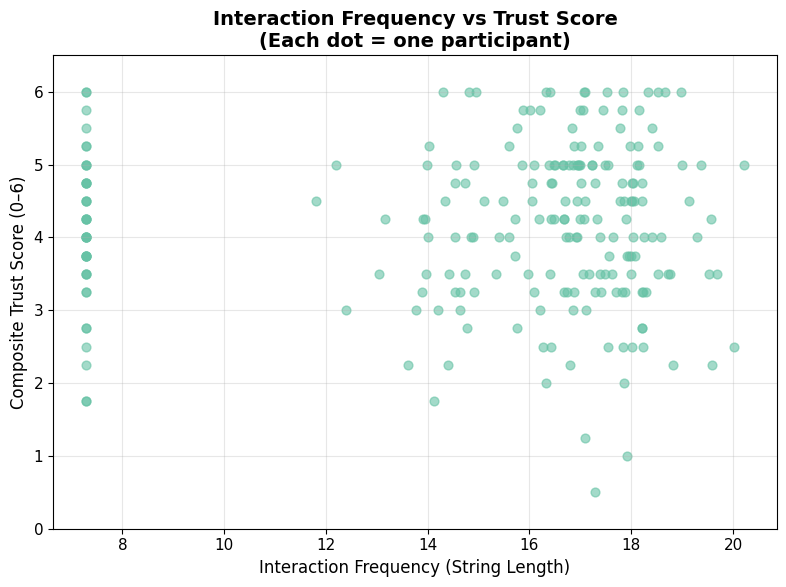

In [31]:
# Scatter plot: Interaction Frequency vs Composite Trust Score (participant-level)
def plot_interaction_vs_trust(data):
	"""
	Scatter plot of interaction frequency vs composite trust score.
	Each dot represents one participant.
	
	Parameters:
	- data: DataFrame containing interaction_freq and trust question responses
	"""
	
 
	# Define the 4 trust questions
	trust_columns = ['skeptical_rating', 'data_trust', 'usability_difficulty', 'trust_composite']
	reverse_columns = ['skeptical_rating', 'usability_difficulty']  # Questions 1 and 3 to flip

	
	# Filter for valid conditions
	valid_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	
	# Check which columns exist
	available_columns = [col for col in trust_columns if col in valid_data.columns]
	missing_columns = [col for col in trust_columns if col not in valid_data.columns]
	
	if missing_columns:
		print(f"Warning: Missing columns: {missing_columns}")
	
	if len(available_columns) == 0:
		print("No trust columns found in data")
		return None
	
	print(f"Using columns: {available_columns}")
	
	# Create reversed scores for specified columns
	for col in available_columns:
		if col in reverse_columns:
			valid_data[f'{col}_rev'] = 6 - valid_data[col]
		else:
			valid_data[f'{col}_rev'] = valid_data[col]
	
	# Calculate composite trust score (average across available questions)
	reversed_columns = [f'{col}_rev' for col in available_columns]
	valid_data['composite_trust_score'] = valid_data[reversed_columns].mean(axis=1, skipna=True)
	
	# Filter for participants with composite scores
	trust_data = valid_data[valid_data['composite_trust_score'].notna()].copy()
	
	# # Filter valid conditions
	interaction_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	interact=interaction_data.groupby('participant_id', as_index=False)['interaction_freq'].sum()
	# print(trust_data['composite_trust_score'])
	plt.figure(figsize=(8, 6))
	print(interact)
	print(len(list(interact)),len(list(trust_data['composite_trust_score'])))
	plt.scatter(
		interact['interaction_freq'],
		trust_data['composite_trust_score'],
		alpha=0.6,
		s=40
	)
	
	plt.xlabel("Interaction Frequency (String Length)", fontsize=12)
	plt.ylabel("Composite Trust Score (0–6)", fontsize=12)
	plt.title("Interaction Frequency vs Trust Score\n(Each dot = one participant)",
			  fontsize=14, fontweight='bold')
	
	plt.grid(alpha=0.3)
	plt.ylim(0, 6.5)
	
	plt.tight_layout()
	plt.show()
	

# Run the scatter plot
plot_interaction_vs_trust(relevant_trials)

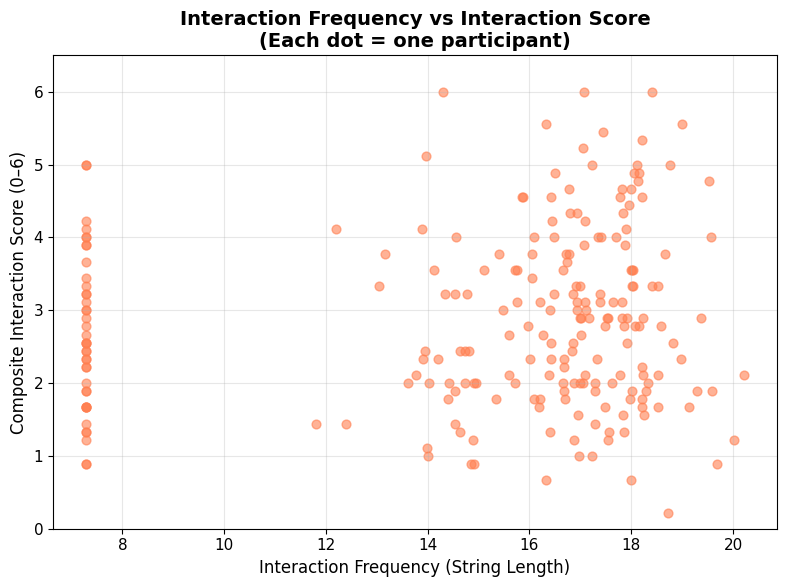

In [32]:
def plot_interaction_vs_interaction_score(data,idata):
		

	# Define interaction question columns
	interaction_cols = ['navigation_control', 'content_control', 'pace_control', 
					'company_communication', 'interface_responsiveness', 
					'customer_communication', 'personal_conversation', 
					'interface_interaction', 'interface_sensitivity']

	
	# Filter for valid conditions
	valid_data = data[
		(data['condition_id'].notna()) & 
		(~data['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	
	valid_data['composite_interaction_score'] = valid_data[interaction_cols].mean(axis=1, skipna=True)
	
	# Filter for participants with composite scores
	# interaction_data = valid_data['usability_difficulty']
	# print(len(valid_data['composite_interaction_score']))
	# # Filter valid conditions
	interaction_data = idata[
		(idata['condition_id'].notna()) & 
		(~idata['condition_id'].isin(['unknown', 'condition_0_historical']))
	].copy()
	interact=interaction_data.groupby('participant_id', as_index=False)['interaction_freq'].sum()

	plt.figure(figsize=(8, 6))


	plt.scatter(
		interact['interaction_freq'],
		valid_data['composite_interaction_score'],
		alpha=0.6,
		s=40,
		color='coral'
	)
	
	plt.xlabel("Interaction Frequency (String Length)", fontsize=12)
	plt.ylabel("Composite Interaction Score (0–6)", fontsize=12)
	plt.title("Interaction Frequency vs Interaction Score\n(Each dot = one participant)",
			  fontsize=14, fontweight='bold')
	
	plt.grid(alpha=0.3)
	plt.ylim(0, 6.5)
	
	plt.tight_layout()
	plt.show()
	

# Run the scatter plot
# print(relevant_trials.usability_composite)
# print(relevant_trials.usability_difficulty)
# print(interaction_data.columns)
plot_interaction_vs_interaction_score(interaction_data,relevant_trials)

8       3.0
9       5.0
29      6.0
30      5.0
50      5.0
       ... 
4550    2.0
4569    4.0
4570    4.0
4589    5.0
4590    4.0
Name: confidence_rating, Length: 452, dtype: float64


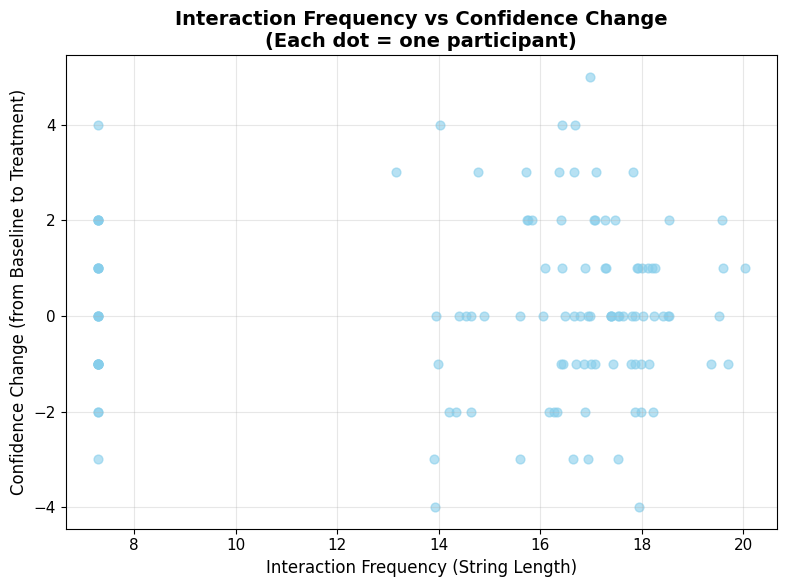

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_interaction_vs_confidence_delta(idata):
    interaction_data = idata[
        (idata['condition_id'].notna()) & 
        (~idata['condition_id'].isin(['unknown', 'condition_0_historical']))
    ].copy()

    # Sum interaction frequency per participant
    interact = interaction_data.groupby('participant_id', as_index=False)['interaction_freq'].sum()

    # Keep rows with confidence ratings and sort by index to preserve order
    conf = interaction_data[['participant_id', 'confidence_rating']].dropna().sort_index().reset_index(drop=True)

    # Compute delta = odd - even (pairwise)
    even_conf = conf.iloc[::2].reset_index(drop=True)
    odd_conf = conf.iloc[1::2].reset_index(drop=True)

    delta = odd_conf.copy()
    delta['confidence_delta'] = odd_conf['confidence_rating'] - even_conf['confidence_rating']

    # Merge with interaction frequency
    merged = interact.merge(delta[['participant_id', 'confidence_delta']], on='participant_id', how='inner')

    plt.figure(figsize=(8, 6))

    plt.scatter(
        merged['interaction_freq'],
        merged['confidence_delta'],
        alpha=0.6,
        s=40,
        color='skyblue'
    )

    plt.xlabel("Interaction Frequency (String Length)", fontsize=12)
    plt.ylabel("Confidence Change (from Baseline to Treatment)", fontsize=12)
    plt.title("Interaction Frequency vs Confidence Change\n(Each dot = one participant)", fontsize=14, fontweight='bold')

    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


print(relevant_trials.confidence_rating.dropna())
plot_interaction_vs_confidence_delta(relevant_trials)

![alt text](SCR-20251208-ovoi-1.png)

In [34]:
# Phase 2 buggy/bad feedback for new conditions (11, 16, 17)
import json
from IPython.display import display

TARGET_CONDITIONS = {
    'condition_11_checkbox': 'Condition 11 - Checkbox Selection',
    'condition_16_tiny_slider': 'Condition 16 - Tiny Slider Checkbox',
    'condition_17_buggy_checkbox': 'Condition 17 - Buggy Checkbox Selection'
}

if 'combined_data' not in globals():
    raise RuntimeError("combined_data is not defined. Run the data-loading cells first.")

feedback_rows = combined_data[
    (combined_data['trial_type'] == 'interaction-feedback') &
    (combined_data['phase'] == 2) &
    (combined_data['condition_id'].isin(TARGET_CONDITIONS.keys()))
].copy()

print(f"Found {len(feedback_rows)} phase-2 interaction-feedback rows for conditions 11/16/17.")

if feedback_rows.empty:
    print("No matching rows found.")
else:
    def parse_feedback(response_value):
        try:
            parsed = json.loads(response_value) if pd.notna(response_value) else {}
        except Exception:
            parsed = {}
        return pd.Series({
            'encounter_bug': parsed.get('encounter_bug', ''),
            'bug_elaboration': parsed.get('bug_elaboration', ''),
            'annoying_design': parsed.get('annoying_design', ''),
            'annoying_elaboration': parsed.get('annoying_elaboration', '')
        })

    parsed_feedback = feedback_rows['response'].apply(parse_feedback).reset_index(drop=True)
    feedback_rows = pd.concat([feedback_rows.reset_index(drop=True), parsed_feedback], axis=1)

    # Compact table view first
    table_cols = [
        'participant_id', 'condition_id', 'encounter_bug', 'bug_elaboration',
        'annoying_design', 'annoying_elaboration'
    ]
    display(feedback_rows[table_cols].sort_values(['condition_id', 'participant_id']).reset_index(drop=True))

    # Detailed printout with question text + text box responses
    for condition_id in sorted(TARGET_CONDITIONS.keys(), key=lambda c: extract_condition_number(c) or 999):
        subset = feedback_rows[feedback_rows['condition_id'] == condition_id].copy()
        if subset.empty:
            continue

        print("\n" + "=" * 90)
        print(f"{TARGET_CONDITIONS[condition_id]} | n={len(subset)}")
        print("=" * 90)

        for _, row in subset.sort_values('participant_id').iterrows():
            bug_text = row['bug_elaboration'] if str(row['bug_elaboration']).strip() else '[empty]'
            annoy_text = row['annoying_elaboration'] if str(row['annoying_elaboration']).strip() else '[empty]'

            print(f"Participant: {row['participant_id']}")
            print(f"  Q1: Did you encounter a bug? -> {row['encounter_bug']}")
            print(f"  Text box (bug elaboration): {bug_text}")
            print(f"  Q2: Was the design annoying/bad? -> {row['annoying_design']}")
            print(f"  Text box (annoying elaboration): {annoy_text}")
            print("-" * 90)


Found 55 phase-2 interaction-feedback rows for conditions 11/16/17.


,participant_id,condition_id,encounter_bug,bug_elaboration,annoying_design,annoying_elaboration
0,5e0b388b15ef4037cebdecc9,condition_11_checkbox,No,,No,
1,5f4df2b4bdb2449bd751ce51,condition_11_checkbox,No,,No,
2,5f6056e9a41e0d14d4c19f4c,condition_11_checkbox,No,,No,
3,6155e95c0808b015514b34e0,condition_11_checkbox,No,,No,
4,62e2deadd18974300540f870,condition_11_checkbox,No,n/a,No,n/a
5,63b63938dbf229f3eb46d4a4,condition_11_checkbox,No,,No,
6,65293fa9b73b0edd4fd93b95,condition_11_checkbox,No,,No,
7,65ccca52871269168cc029b5,condition_11_checkbox,No,,No,
8,663280033a30e30383a6a5e9,condition_11_checkbox,No,NA,No,NA
9,66a02d45a7db35d93c9f6a81,condition_11_checkbox,No,,No,



Condition 11 - Checkbox Selection | n=18
Participant: 5e0b388b15ef4037cebdecc9
  Q1: Did you encounter a bug? -> No
  Text box (bug elaboration): [empty]
  Q2: Was the design annoying/bad? -> No
  Text box (annoying elaboration): [empty]
------------------------------------------------------------------------------------------
Participant: 5f4df2b4bdb2449bd751ce51
  Q1: Did you encounter a bug? -> No
  Text box (bug elaboration): [empty]
  Q2: Was the design annoying/bad? -> No
  Text box (annoying elaboration): [empty]
------------------------------------------------------------------------------------------
Participant: 5f6056e9a41e0d14d4c19f4c
  Q1: Did you encounter a bug? -> No
  Text box (bug elaboration): [empty]
  Q2: Was the design annoying/bad? -> No
  Text box (annoying elaboration): [empty]
------------------------------------------------------------------------------------------
Participant: 6155e95c0808b015514b34e0
  Q1: Did you encounter a bug? -> No
  Text box (bug ela